# Кластеризация

Кластеризация &mdash; это метод машинного обучения, который включает группировку данных в пространстве признаков. Теоретически, точки, находящиеся в одной группе (кластере), должны иметь схожие свойства, в то время как точки в разных группах должны иметь (сильно) отличающиеся свойства.

Кластеризация является методом обучения без учителя (вопрос: чем отличаются методы обучения с учителем и без учителя?) и распространенным методом статистического анализа данных, используемым во многих областях. В частности используется при составлении портретов пользователей, поиске аномалий, анализе геоданных, представлении рыночной информации.

В анализе данных часто прибегают к кластеризации, чтобы получить ценную информацию из данных, наблюдая, в какие группы попадают точки при применении алгоритма кластеризации.




# K-means

Напомним, что сам алгоритм можно схематически представить в виде следующих шагов:

1. Инициализируем центры кластеров случайным образом (должно быть задано количество кластеров).
2. Относим точки к соответствующим кластерам (с минимальным расстоянием до их центра).
3. Производится пересчет центров кластеров по формуле центра масс для всех точек, принадлежащих кластеру.
4. Пункты 2-3 повторяются до тех пор пока центры кластеров перестанут меняться (сильно).

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
plt.rcParams['figure.figsize'] = [11, 8]

Посмотрим на то, как работает метод.

In [3]:
from sklearn.cluster import KMeans

np.random.seed(123)
X1 = np.random.randn(100,2)
X2 = np.random.randn(100,2) - np.array([10,1])
X3 = np.random.randn(100,2) - np.array([1,10])
X = np.vstack((X1,X2,X3))
y = np.array([1]*100 + [2]*100 + [3]*100)

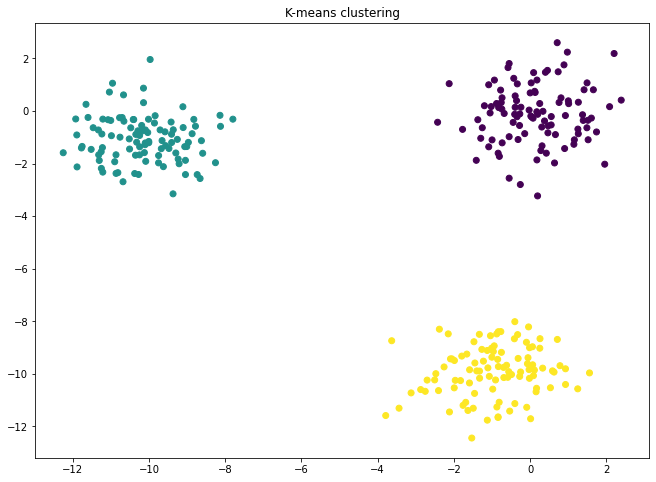

In [4]:
k_means = KMeans(n_clusters = 3)
k_means = k_means.fit(X)
clusters = k_means.predict(X)
plt.scatter(X[:,0], X[:,1], c = clusters)
plt.title('K-means clustering')
plt.show()

Посмотрим, что будет происходить, если мы не угадали с числом кластеров.

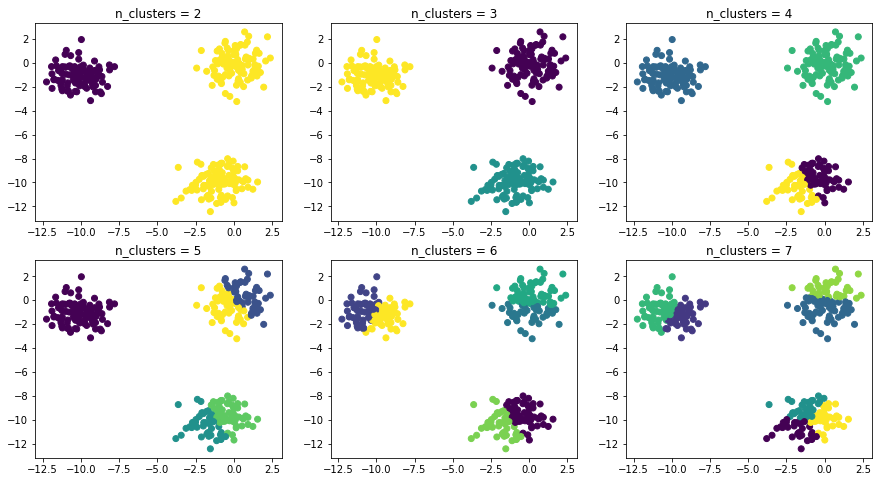

In [5]:
plt.figure(figsize= (15,8))
for n_c in range(2,8):
    k_means = KMeans(n_clusters = n_c)
    k_means = k_means.fit(X)
    clusters = k_means.predict(X)
    plt.subplot(2,3,n_c - 1)
    plt.scatter(X[:,0], X[:,1], c = clusters)
    plt.title('n_clusters = {}'.format(n_c))

plt.show()

Как мы видим, k-means обязательно пытается отдать каждому кластеру какие-то объекты и, как большинство алгоритмов кластеризации, зависит от заданного числа кластеров. Есть огромное количество вариаций, как выбирать количество кластеров автоматически — например, ввести вероятностный подход к выбору числа кластеров, но данные методы мы не будем рассматривать в этом курсе.

Одним из главных недостатков k-means является случайная инициализация центров кластеров, что может привести к различным результатам кластеризации.

Главным же достоинством является скорость алгоритма. На каждой итерации требуется пересчет только расстояний до центров кластеров.

Также есть вариация k-medians, которая использует медиану вместо среднего. Это позволяет алгоритму стать более устойчивым к выбросам.

[Визуализация работы K-Means](https://www.naftaliharris.com/blog/visualizing-k-means-clustering/)

# Оценка качества кластеризации

В случае, когда неизвестны истинные лейблы (внешняя информация), могут быть использованы внутренние меры качества кластеризации, которые оценивают качество структуры кластеров:

* компактность (cohesion) - чем ближе (более похожи) объекты в кластере, тем лучше
* отделимость (separation) - чем дальше друг от друга (менее похожи)  находятся объекты из разных кластеров, тем лучше

Например, **индекс Силуэта** (Silhouette Coefficient):

$$Sil(X, C) = \frac{1}{|C|}\sum_{c_k \in C}\frac{1}{|c_k|}\sum_{x_i \in c_k}\frac{separation(x_i, c_k) - cohension(x_i, c_k)}{max\{separation(x_i, c_k) , cohension(x_i, c_k)\}}$$

где

$separation(x_i, c_k) = min_{c_l \in C ∖ \{c_k\}} \{\frac{1}{|c_l|}\sum_{x_j \in c_l}||x_i - x_j||\}$ - среднее расстояние до объектов ближайшего кластера

$cohension(x_i, c_k) = \frac{1}{|c_k|-1}\sum_{x_j \in c_k}||x_i - x_j||$ - среднее расстояние до объектов того же кластера


$-1 \le Sil(X, C) \le 1$

Чем ближе к 1, тем лучше. Значения около 0 - пересекающиеся кластера. Отрицательные - обычно объектам присовены не те кластеры, так как объекты других кластеров более похожи, чем объекты из одного.

In [6]:
from sklearn.metrics import silhouette_score

best_k, best_score = None, -1
for k in range(2,15):
    k_means = KMeans(n_clusters = k)
    k_means = k_means.fit(X)
    clusters = k_means.predict(X)
    score = np.round(silhouette_score(X=X,
                             labels=clusters), 2)
    if score > best_score:
      best_score = score
      best_k = k
print('Best score {}, k = {}'.format(best_score, best_k))

Best score 0.82, k = 3


# DBSCAN

(Density-based spatial clustering of applications with noise)

Это алгоритм, основанный на плотности — если дан набор объектов в некотором пространстве, алгоритм группирует вместе объекты, которые расположены близко и помечает как выбросы (шум) объекты, которые находятся в областях с малой плотностью (ближайшие соседи которых лежат далеко).

Алгоритм имеет два основных гиперпараметра:
1. `eps` &mdash; радиус рассматриваемой окрестности
2. `min_samples` &mdash; число соседей в окрестности

Для выполнения кластеризации DBSCAN точки делятся на основные точки, достижимые по плотности точки и выпадающие следующим образом:

- Точка $p$ является основной точкой, если по меньшей мере `min_samples` точек находятся на расстоянии, не превосходящем
`eps` от неё. Говорят, что эти точки достижимы прямо из $p$.

-  Точка $q$ прямо достижима из $p$, если точка $q$ находится на расстоянии, не большем `eps`, от точки $p$, и $p$ — основная точка.
Точка $q$ достижима из $p$, если имеется путь
$p_1,…,p_n$ где $p_1=p$ и $p_n=q$ , а каждая точка $p_{i+1}$ достижима прямо из $p_i$ (все точки на пути должны быть основными, за исключением $q$).

Все точки, не достижимые из основных точек, считаются шумом.

Теперь, если $p$ является основной точкой, то она формирует кластер вместе со всеми точками (основными или неосновными), достижимыми из этой точки. Каждый кластер содержит по меньшей мере одну основную точку. Неосновные точки могут быть частью кластера, но они формируют его «край», поскольку не могут быть использованы для достижения других точек.



Рассмотрим диаграмму, параметр `min_samples`=4.

Точка $A$ и другие красные точки являются основными точками, поскольку область с радиусом
`eps` , окружающая эти точки, содержит по меньшей мере 4 точки (включая саму точку). Поскольку все они достижимы друг из друга, точки образуют один кластер. Точки $B$ и $C$ основными не являются, но достижимы из $A$ (через другие основные точки), и также принадлежат кластеру. Точка $N$ является точкой шума, она не является ни основной точкой, ни доступной прямо.

<p><a href="https://commons.wikimedia.org/wiki/File:DBSCAN-Illustration.svg#/media/Файл:DBSCAN-Illustration.svg"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/a/af/DBSCAN-Illustration.svg/1200px-DBSCAN-Illustration.svg.png" alt="DBSCAN-Illustration.svg" width="450" height="450"> </a><br>Автор: <a href="//commons.wikimedia.org/wiki/User:Chire" title="User:Chire">Chire</a> &mdash; <span class="int-own-work" lang="ru">собственная работа</span>, <a href="https://creativecommons.org/licenses/by-sa/3.0" title="Creative Commons Attribution-Share Alike 3.0">CC BY-SA 3.0</a>

Посмотрим на результаты кластеризации при разном выборе параметров `eps` и `min_samples`.

Шумовые точки помечаются -1

In [7]:
clusters

array([ 3,  6,  4,  3,  0,  3,  0,  3,  4, 13,  4,  3,  3,  0,  6,  6,  3,
       13,  4,  3,  6,  3, 13,  0,  4,  6,  0,  4,  4,  4,  3,  6,  4, 13,
        3, 13,  0,  3,  3,  6,  0,  4,  6,  6,  0,  0,  4,  4,  6, 13,  6,
        4, 13,  6,  6,  4,  3, 13,  3,  0, 13,  4,  0, 13, 13,  6,  3, 13,
        4,  0,  3, 13, 13,  4,  3, 13,  6,  3, 13,  0, 13,  4, 13,  0, 13,
        3,  3,  4, 13,  3,  4,  0,  6,  6,  3, 13, 13,  6,  3,  3,  1, 11,
        1,  1,  8, 11,  1,  8, 11,  8, 10,  1,  1, 10,  8,  8,  8,  1, 11,
       11, 11,  1,  1,  1,  8, 11, 10, 11, 11,  8,  1,  1, 11, 11, 11, 10,
       11, 10,  1, 10, 10, 10,  1,  8,  8,  8,  1,  8, 11,  8,  1,  8,  8,
        8,  1, 11,  8, 11,  1,  8, 10,  1,  1, 10,  8,  8,  8,  1,  8,  1,
        1, 11, 10,  8,  8,  1, 10, 10,  8, 10,  8,  8,  8, 11, 11, 10, 11,
        8,  8,  1,  1, 10,  8,  8,  1, 11,  1, 10,  8,  8,  9,  2,  7, 12,
        7,  7,  5,  2,  9,  2,  5,  2,  2,  7,  5,  5,  2,  7,  2,  9,  9,
        5,  9,  5,  9,  2

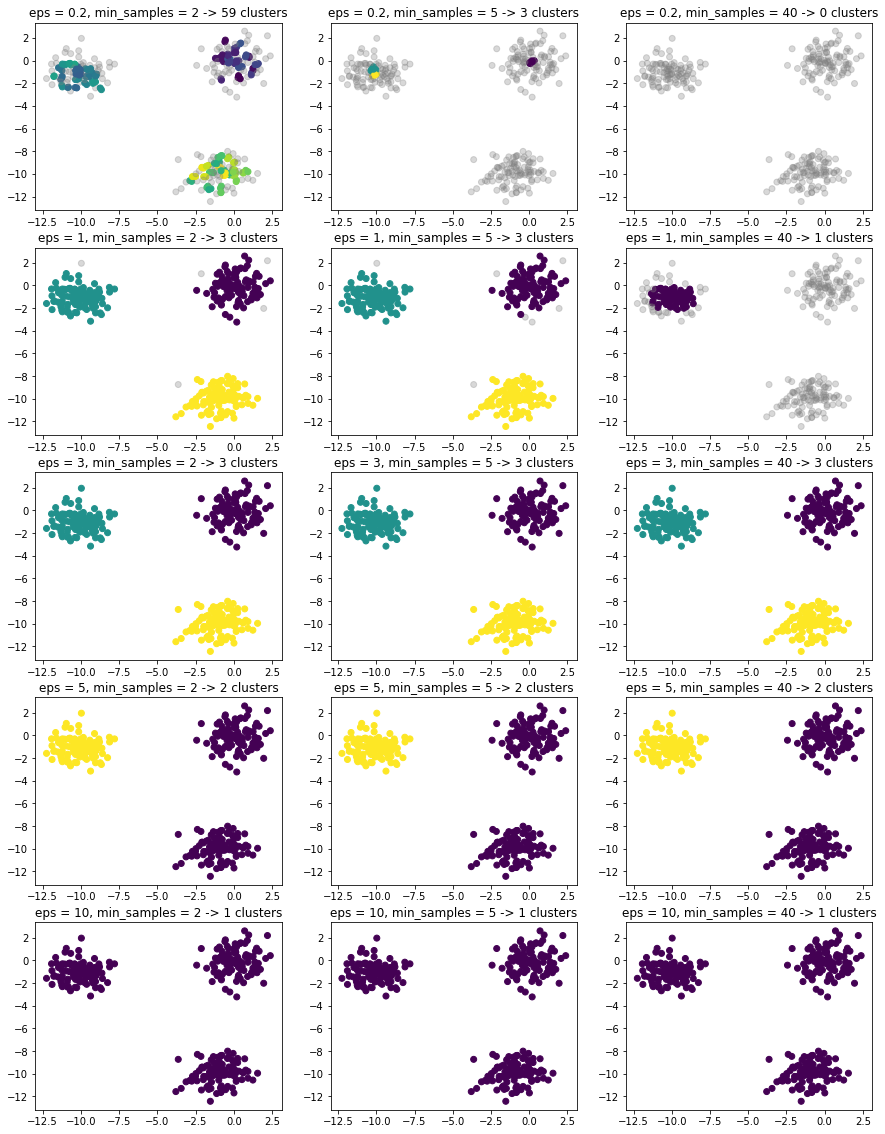

In [8]:
from sklearn.cluster import DBSCAN
import matplotlib as mpl

def get_colors(clusters):
  n_clusters = len(np.unique(clusters[clusters != -1]))

  palette = mpl.colormaps['viridis'].resampled(n_clusters)(np.linspace(0, 1, n_clusters))
  colors = np.zeros((clusters.shape[0], 4))
  colors[clusters != -1] = palette[clusters[clusters != -1]]

  #Шум будет серо-прозрачным
  colors[clusters == -1] = [0.5, 0.5, 0.5, 0.3]

  return colors

plt.figure(figsize= (15,20))
i = 1

for e in [0.2, 1, 3, 5, 10]:
    for samples in [2, 5, 40]:
        dbscan = DBSCAN(eps=e, min_samples=samples)
        clusters = dbscan.fit_predict(X)

        n_clusters = len(np.unique(clusters[clusters != -1]))
        colors = get_colors(clusters)

        plt.subplot(5, 3, i)

        plt.scatter(X[:,0], X[:,1], c=colors)
        plt.title('eps = {}, min_samples = {} -> {} clusters'.format(e, samples, n_clusters))
        i += 1


plt.show()

[Визуализация работы DBSCAN](https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/)
(Стоит посмотреть)

Результаты работы методов на других датасетах:

In [9]:
from sklearn.datasets import make_moons, make_circles

In [11]:
X, y = make_moons(n_samples=500, noise=0.1)

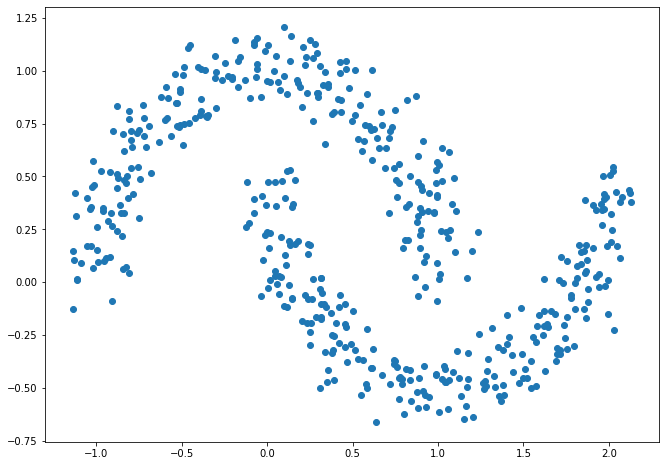

In [12]:
plt.scatter(X[:,0], X[:,1])
plt.show()

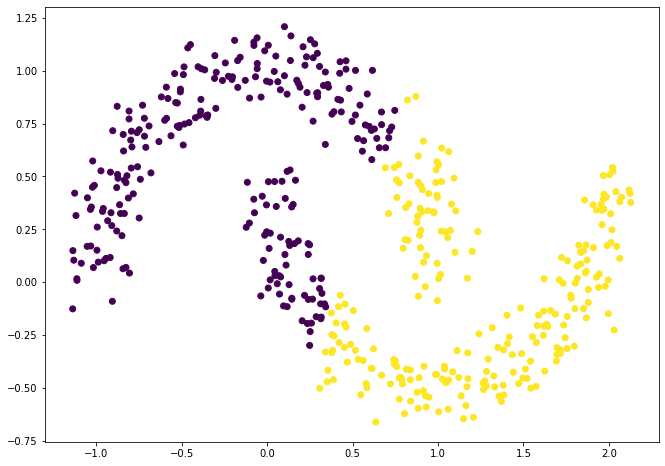

In [13]:
k_means = KMeans(n_clusters = 2)
k_means = k_means.fit(X)
clusters = k_means.predict(X)

colors = get_colors(clusters)
plt.scatter(X[:,0], X[:,1], c=colors)
plt.show()

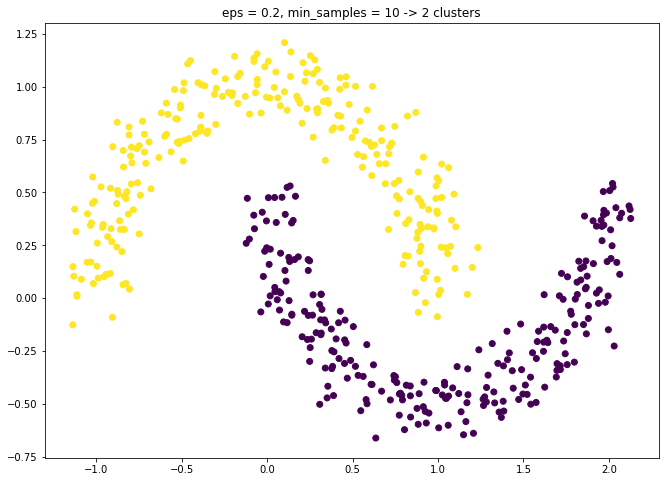

In [14]:
dbscan = DBSCAN(eps=0.2, min_samples=10)
clusters = dbscan.fit_predict(X)

colors = get_colors(clusters)
plt.scatter(X[:,0], X[:,1], c=colors)
plt.title('eps = {}, min_samples = {} -> {} clusters'.format(dbscan.eps, dbscan.min_samples, len(np.unique(clusters[clusters != -1]))))
plt.show()

Как вы думаете, почему так выходит? (Пояснения ниже)

In [15]:
X, y = make_circles(n_samples=500, noise=0.05, factor=0.5)

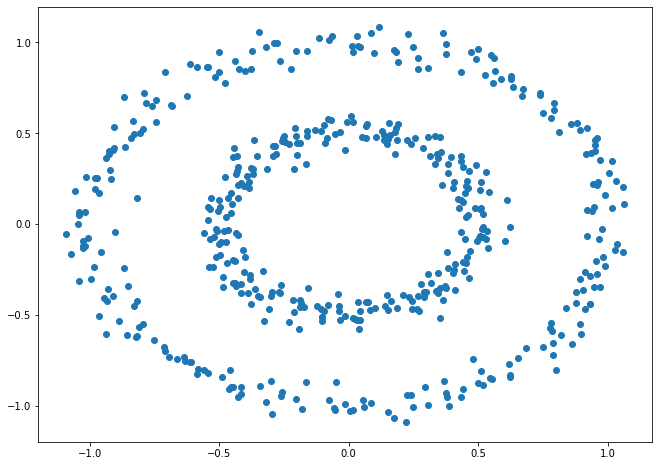

In [16]:
plt.scatter(X[:,0], X[:,1])
plt.show()

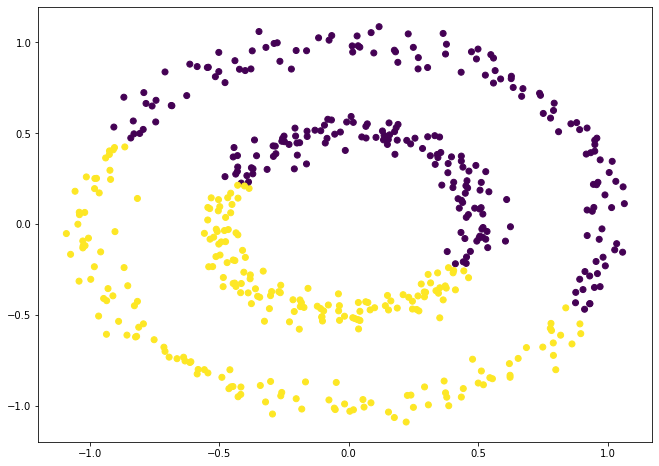

In [26]:
k_means = KMeans(n_clusters = 2)
k_means = k_means.fit(X)
clusters = k_means.predict(X)
plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

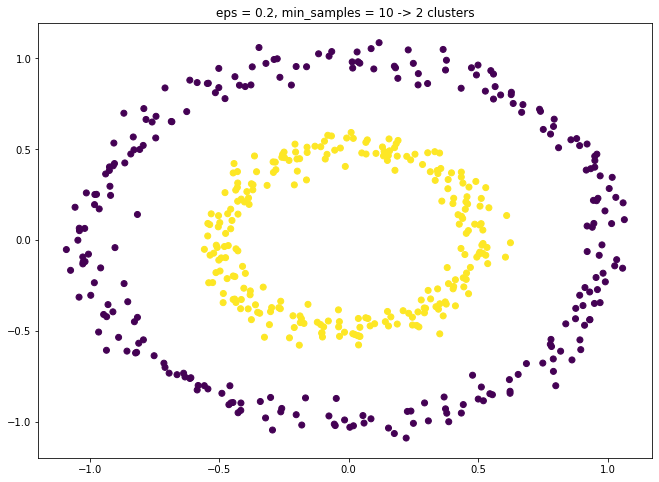

In [27]:
dbscan = DBSCAN(eps=0.2, min_samples=10)
clusters = dbscan.fit_predict(X)
colors = get_colors(clusters)
plt.scatter(X[:,0], X[:,1], c=colors)
plt.title('eps = {}, min_samples = {} -> {} clusters'.format(dbscan.eps, dbscan.min_samples, len(np.unique(clusters[clusters != -1]))))
plt.show()

k-Means выделяет только выпуклые кластеры, сходного размера. Не очень хорошо работает с шумными данными. Хуже видит аномалии. С другой стороны, k-means лучше справляется с большими данными и размерностью, а также разреженными данными с переменной плотностью (DBSCAN скорее относит разные плотности к разным кластерам).

# Иерархическая кластеризация

Другим вариантом к построению кластеров является иерархический подход, в котором алгоритм жадным образом строит кластеры. Существует два варианта иерархической кластеризации:

1. аггломеративная, в которой алгоритм на каждой итерации объединяет два меньших кластера в один
2. дивизивная, в которой алгоритм на каждой итерации разбивает один кластер на два более мелких

Мы рассмотрим аггломеративный подход к кластеризации (дивизивный можно рассмотреть по аналогии).

Опишем схематически алгоритм аггломеративной иерархической кластеризации:

- Инициализируем наше множество кластеров, каждая точка считается своим кластером. То есть для выборки размера $N$ у нас на первой итерации будет $N$ кластеров. Также в качестве входного параметра алгоритму подается метрика расстояния между двумя кластерами. Одной из популярных метрик является расстояние Уорда.

- На каждой итерации  мы объединяем два кластера в один. Объединяющиеся кластера выбираются в соответствии с наименьшим расстоянием Уорда. То есть в соответствии с выбранным нами расстоянием эти два кластера будут наиболее похожи и поэтому объединяются.

- Предыдущий шаг повторяется вплоть до объединения всех точек один кластер.

Расстояние Уорда — между кластерами берётся прирост суммы квадратов расстояний объектов до центра кластера, получаемого в результате их объединения.

$$
\Delta = \sum_{x_i \in A \cup B}{(x_i-\bar{x})^2} - \sum_{x_i \in A}(x_i - \bar{a})^2 - \sum_{x_i \in B}(x_i - \bar{b})^2
$$

В результате в данном подходе мы можем выбрать любое количество кластеров после завершения процедуры, просто остановив алгоритм на нужном нам шаге. К тому же данный алгоритм гораздо менее чувствителен к выбору метрики между точками, тогда как другие алгоритмы сильно зависят от этого.

Для визуализации иерархической кластеризации удобно строить дендрограммы, в которых разница между уровнями равна выбранному расстоянию объединяющихся на данном этапе кластеров.

Посмотрим на иерархическую кластеризацию на примере:


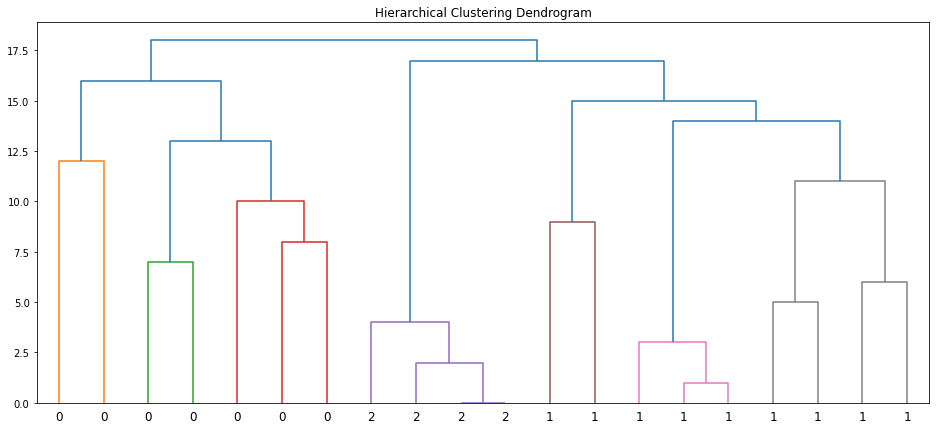

In [28]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    # linkage matrix format: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


iris = load_iris()
X = iris.data[:20]
model = AgglomerativeClustering(n_clusters=3)

model = model.fit(X)
plt.figure(figsize=(16,7))
plot_dendrogram(model, labels=model.labels_)
plt.title('Hierarchical Clustering Dendrogram')
plt.show()

Если нет каких-то специализированных условий (например, известно, что кластеров должно быть не более $K$), то число кластеров можно выбирать по резкому скачку дендрограммы. Кроме того, в некоторых задачах важно понимать, для чего делается кластеризация и доменную область задачи — исходя из этого можно сильно сократить искомое количество кластеров.

Также в иерархическую кластеризацию можно передавать дополнительную информацию вида *I-я и J-я точки "похожи"*. Это задается через матрицу связей.

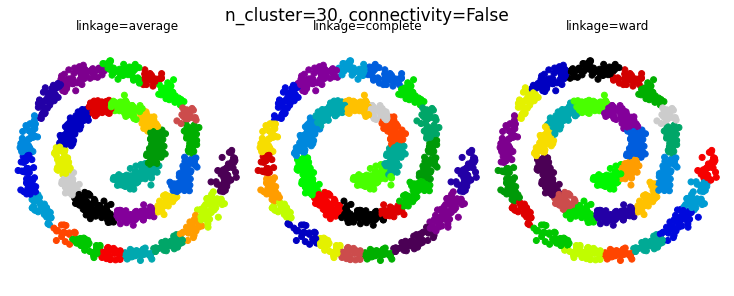

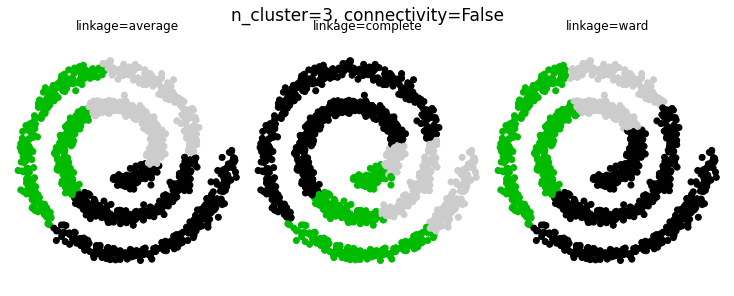

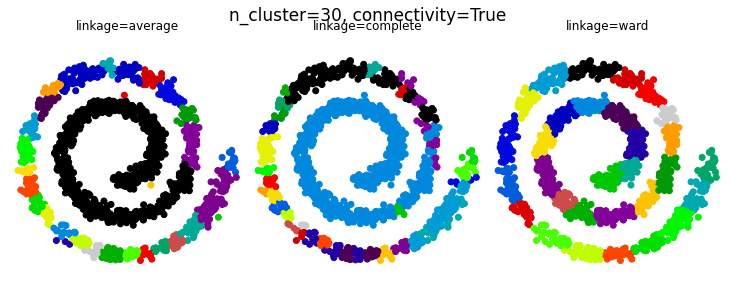

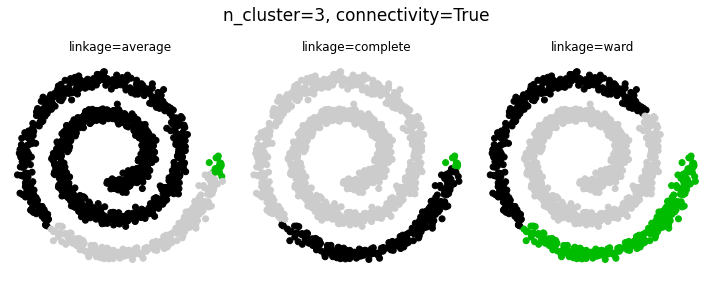

In [29]:
import time
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

# Generate sample data
n_samples = 1500
np.random.seed(0)
t = 1.5 * np.pi * (1 + 3 * np.random.rand(1, n_samples))
x = t * np.cos(t)
y = t * np.sin(t)


X = np.concatenate((x, y))
X += .7 * np.random.randn(2, n_samples)
X = X.T

# Create a graph capturing local connectivity. Larger number of neighbors
# will give more homogeneous clusters to the cost of computation
# time. A very large number of neighbors gives more evenly distributed
# cluster sizes, but may not impose the local manifold structure of
# the data
knn_graph = kneighbors_graph(X, 30, include_self=False)

for connectivity in (None, knn_graph):
    for n_clusters in (30, 3):
        plt.figure(figsize=(10, 4))
        for index, linkage in enumerate(('average',
                                         'complete',
                                         'ward')):
            plt.subplot(1, 3, index + 1)
            model = AgglomerativeClustering(linkage=linkage,
                                            connectivity=connectivity,
                                            n_clusters=n_clusters)
            model.fit(X)
            plt.scatter(X[:, 0], X[:, 1], c=model.labels_,
                        cmap=plt.cm.nipy_spectral)
            plt.title('linkage=%s' % linkage,
                      fontdict=dict(verticalalignment='top'))
            plt.axis('equal')
            plt.axis('off')

            plt.subplots_adjust(bottom=0, top=.89, wspace=0,
                                left=0, right=1)
            plt.suptitle('n_cluster=%i, connectivity=%r' %
                         (n_clusters, connectivity is not None), size=17)

plt.tight_layout()
plt.show()

Пояснения:

linkage - метрика расстояния между кластерами:


*   ‘ward’ расстояние Уорда
*   ‘average’ - среднее расстояние между всеми объектами двух кластеров
*   ‘complete’ - максимальное расстояние между всеми объектами двух кластеров


connectivity - матрица связей (или что-то, из чего ее можно получить):

*  False в названии графика - None  (никакая структура не учитывается)
*  True в названии графика - kneighbors_graph

# Сравнение работы алгоритмов

Сгенерируем кластеры разной формы и посмотрим на результаты работы алгоритмов

Automatically created module for IPython interactive environment


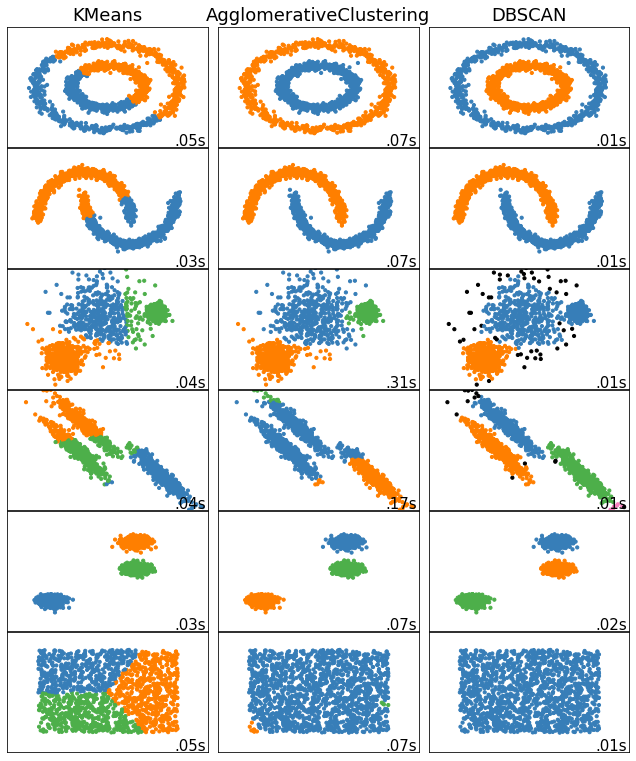

In [30]:
print(__doc__)

import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
warnings.simplefilter('ignore')

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(3 * 2 + 3, 10.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3,
                'min_samples': 20,
                'xi': 0.05,
                'min_cluster_size': 0.1}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2,
                     'min_samples': 20, 'xi': 0.25}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2,
              'min_samples': 5, 'xi': 0.035, 'min_cluster_size': .2}),
    (aniso, {'eps': .15, 'n_neighbors': 2,
             'min_samples': 20, 'xi': 0.1, 'min_cluster_size': .2}),
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)

    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============

    k_means = cluster.KMeans(n_clusters=params['n_clusters'])


    dbscan = cluster.DBSCAN(eps=params['eps'])

    average_linkage =  cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)


    clustering_algorithms = (
        ('KMeans', k_means),
        ('AgglomerativeClustering', average_linkage),
        ('DBSCAN', dbscan),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()

# Бонус: кластеризуем координаты российских населенных пунктов и яблоки

* (А также k-Means своими руками и опциональное задание)

In [31]:
import pandas
data = pandas.read_csv('https://raw.githubusercontent.com/nadiinchi/HSE_minor_DataAnalysis_seminars_iad16/master/materials/sem_b3_coord.csv')

In [32]:
data.head()

LAT        LONG
0  49.987000  142.157883
1  49.964722  143.263031
2  49.822498  142.154556
3  49.770195  144.087326
4  49.668335  144.100281

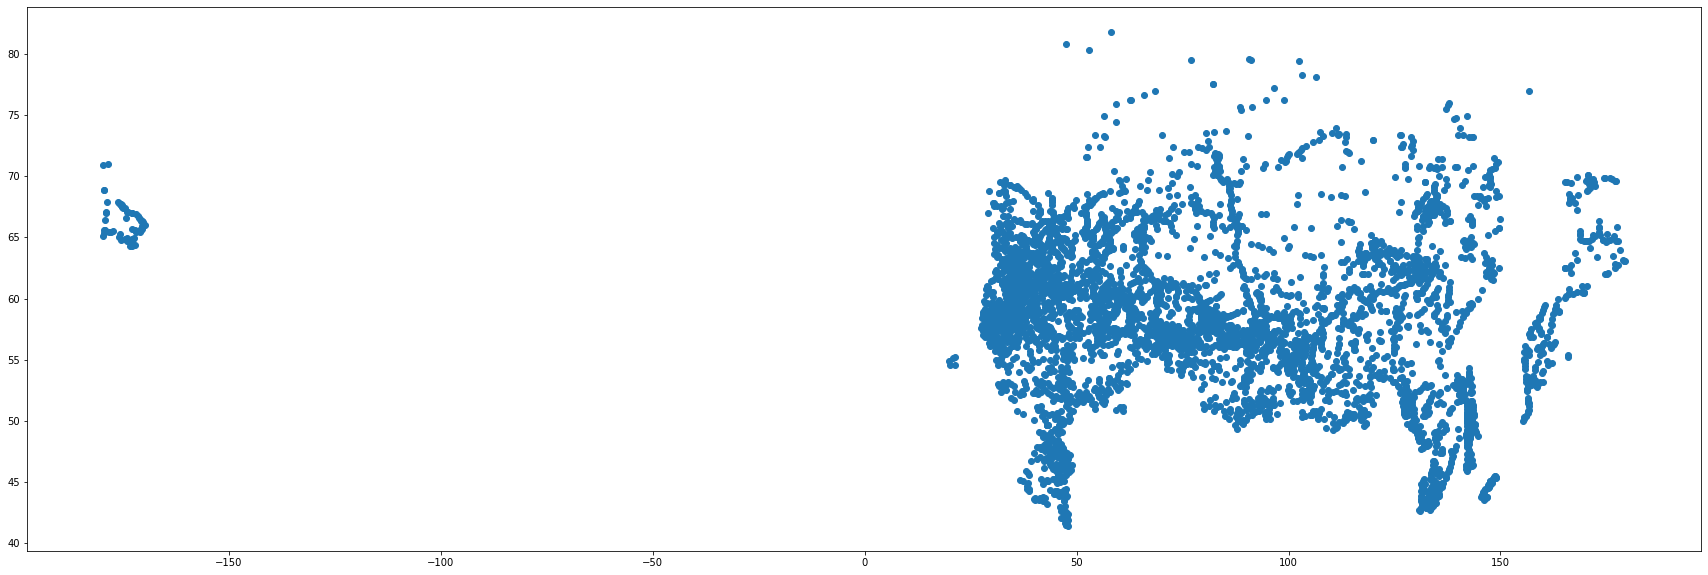

In [33]:
# Просто показываем точки

plt.figure(figsize= (30,10))
plt.scatter(data['LONG'], data['LAT'])

In [34]:
from sklearn.metrics import pairwise_distances

class k_means:
    def __init__(self, n_clusters):
        # гиперпараметр - количество кластеров
        self.n_clusters = n_clusters

    def fit(self, X, max_iter=10, visualize=False):
        """
        X - выборка размера количество объектов x количество признаков
        max_iter - максимальное число итераций
        visualize - визуализировать точки ("карту") на каждой итерации
                    (реализуйте поддержку этого флага, только если уже реализовали алгоритм)
        """
        # Цель: обучить центры кластеров self.centers, форма: число кластеров x число признаков

        # Шаг 0: сколько объектов и признаков?
        num_obj = X.shape[0]
        num_feat = X.shape[1]

        # Шаг 1.1: инициализируйте y - вектор длины число объектов,
        # хранящий, к какому кластеру относится каждый объект
        # каждый элемент - случайно выбранный номер кластера (используйте np.random.randint)
        y = np.random.randint(0, self.n_clusters, size=num_obj)

        # Шаг 1.2: создайте матрицу для хранения центров кластеров (используйте np.zeros)
        self.centers = np.zeros((self.n_clusters, num_feat))

        for _ in range(max_iter):
            # Шаг 2: обновите центры кластеров (используйте цикл по номерам кластеров, индексацию, np.mean)
            for c in range(self.n_clusters):
                self.centers[c] = X[y==c].mean(axis=0) # вектор длины num_feat
            # Шаг 3: обновите y. Для этого вычислите расстояния между всеми объектами
            # и центрами кластеров (используйте pairwise_distances),
            # затем найдите ближайший к каждому объекту кластер (используйте np.argmin с указанием axis)
            dists = pairwise_distances(X, self.centers) # число объектов на число окластеров
            # shape (num_obj, self.n_clusters)
            y = np.argmin(dists, axis=1) # вектор длины число объектов

            # (опциональный пункт)
            # Здесь можно реализовать поддержку фрага visualize и отрисовать карту, если visualize=True
            # Отрисовывать точки нужно с помощью plt.scatter, в конце отрисовки графика используйте plt.show()
            if visualize:
                plt.figure(figsize= (30,10))
                plt.scatter(X[:, 1], X[:, 0], c=y)
                plt.show()

    def transform(self, X):
        """
        X - выборка размера количество объектов x количество признаков
        """
        # Цель: вернуть y - номера кластеров, к которым относится каждый объект
        # вектор длины число объектов в X
        dists = pairwise_distances(X, self.centers)
        return np.argmin(dists, axis=1)

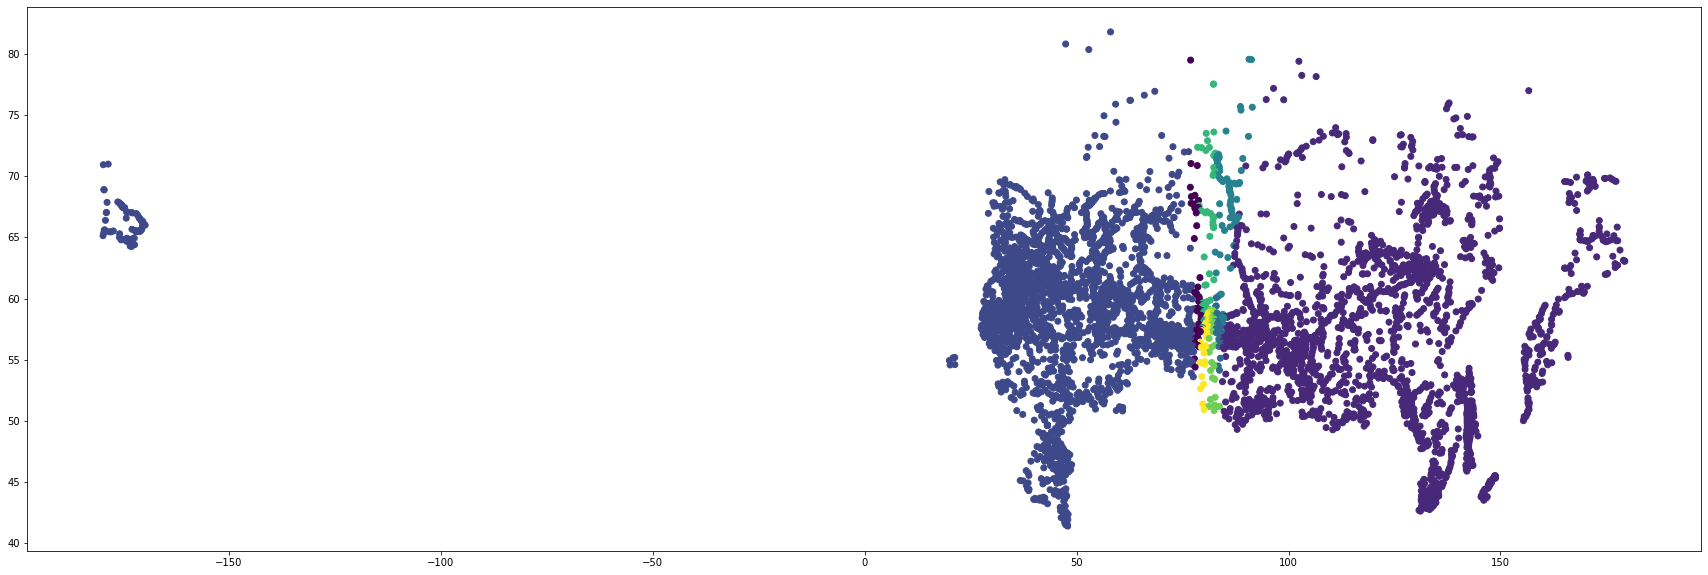

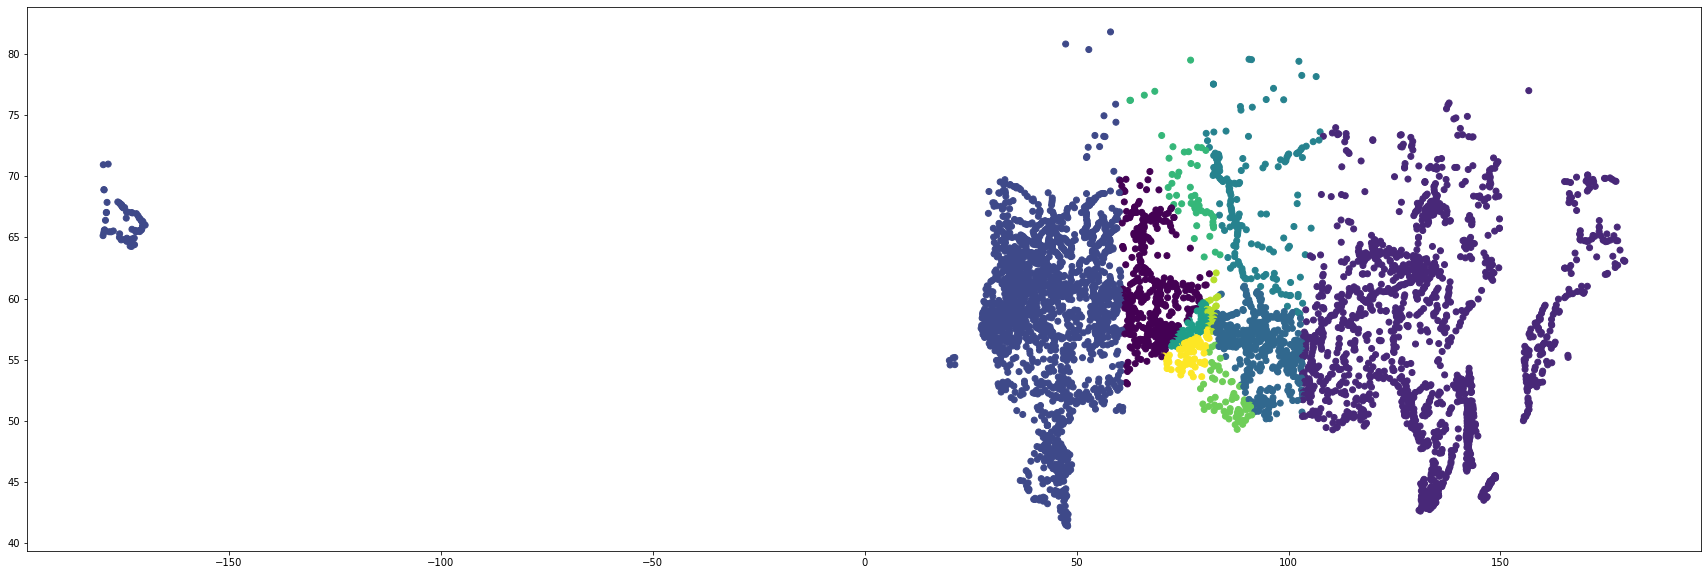

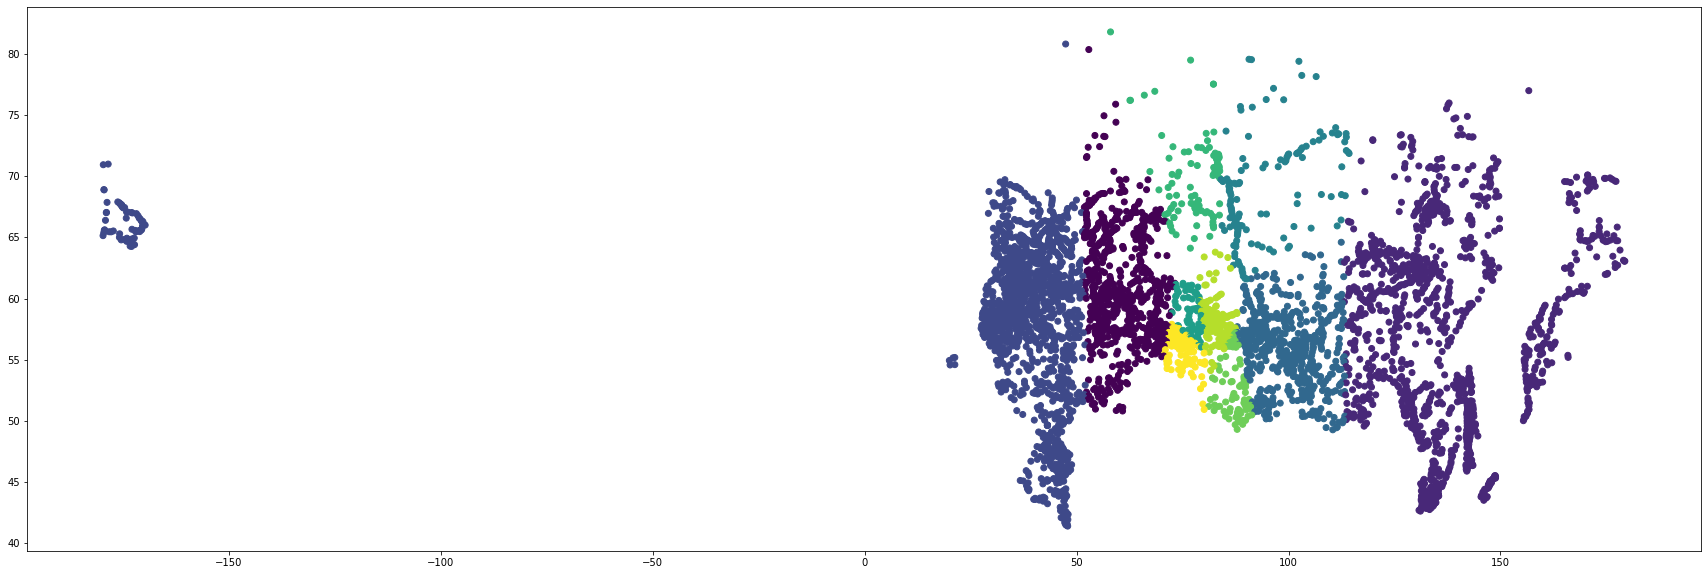

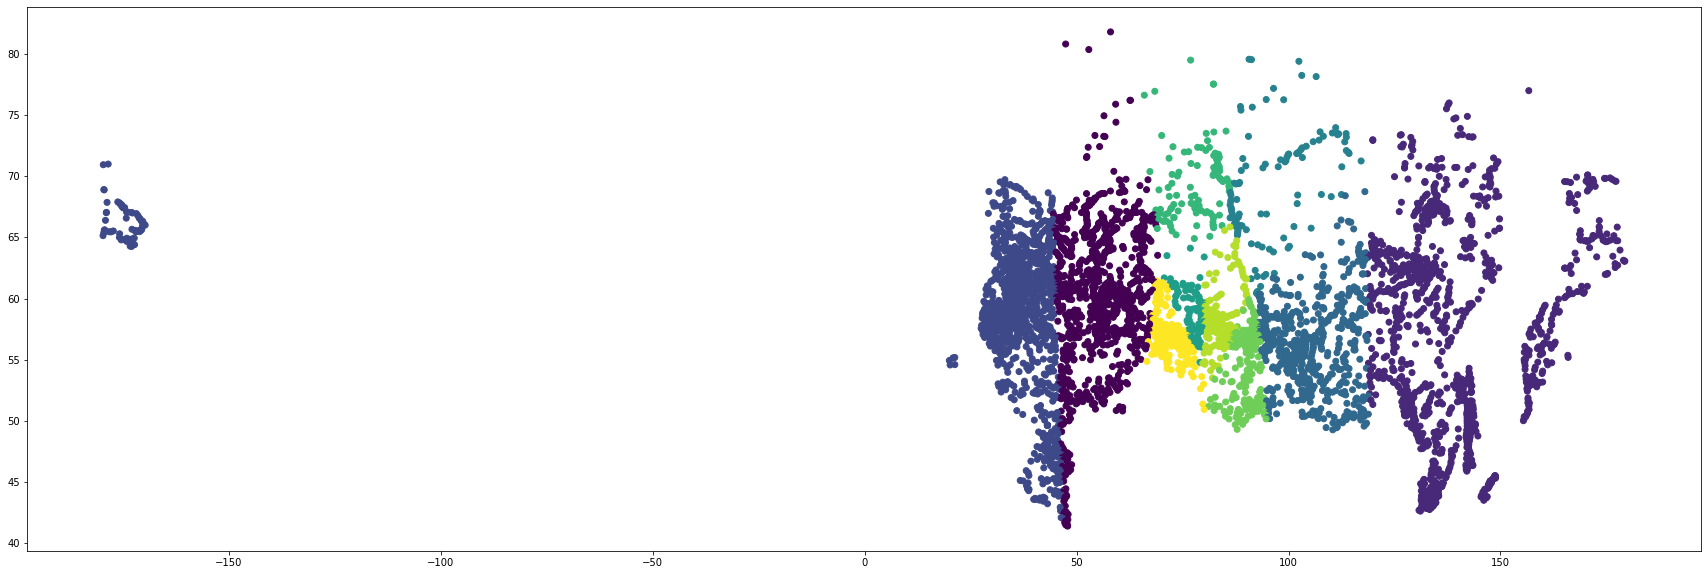

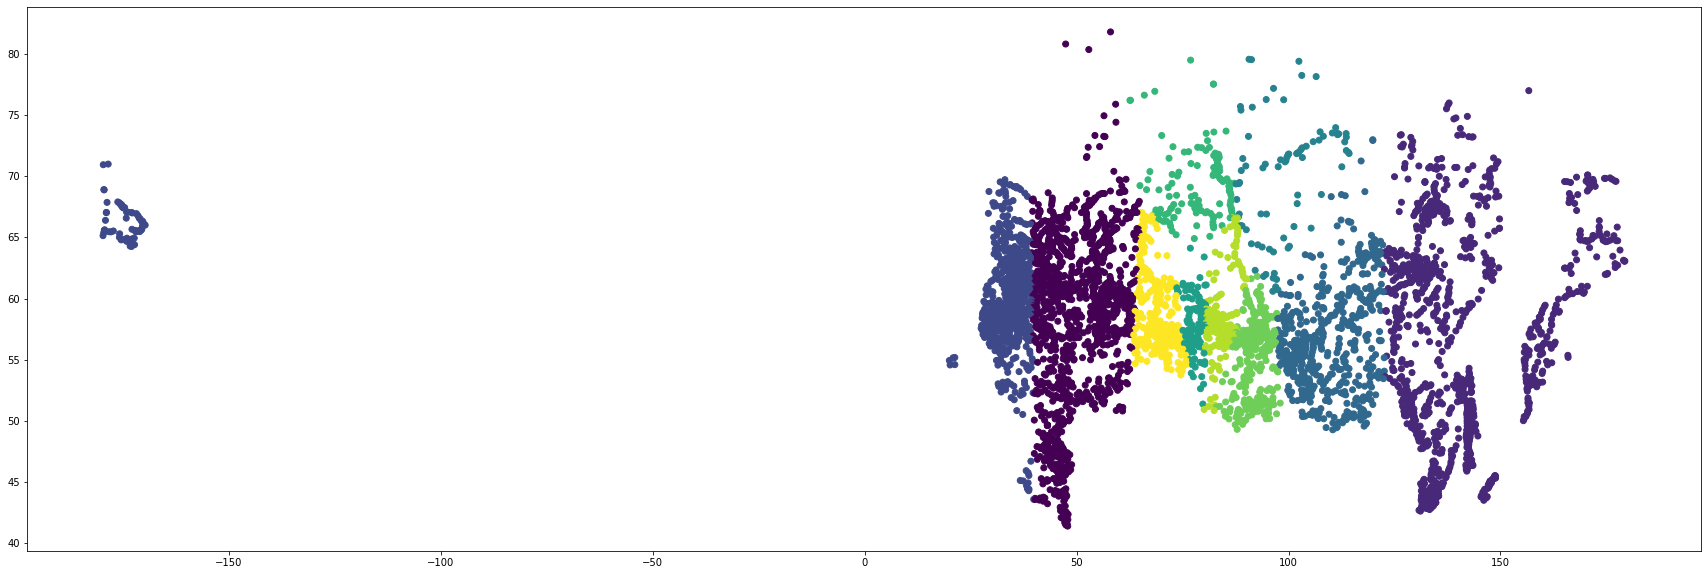

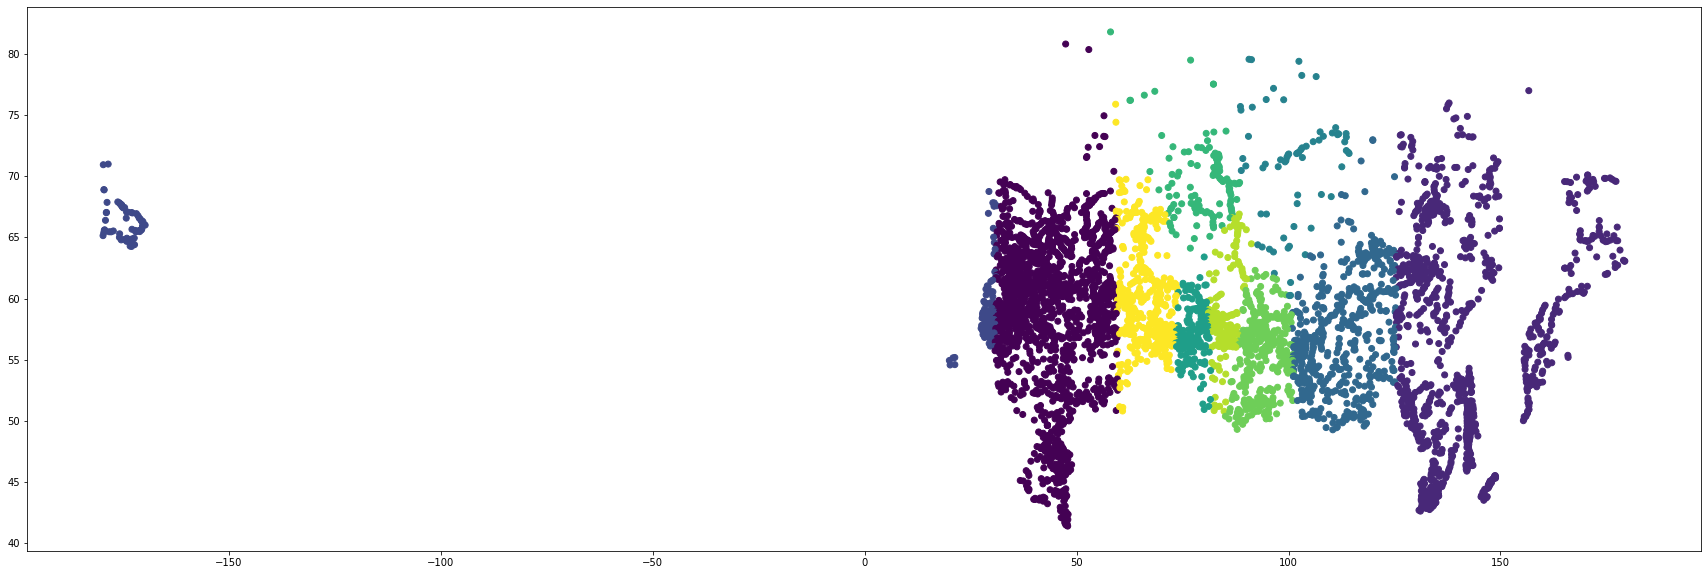

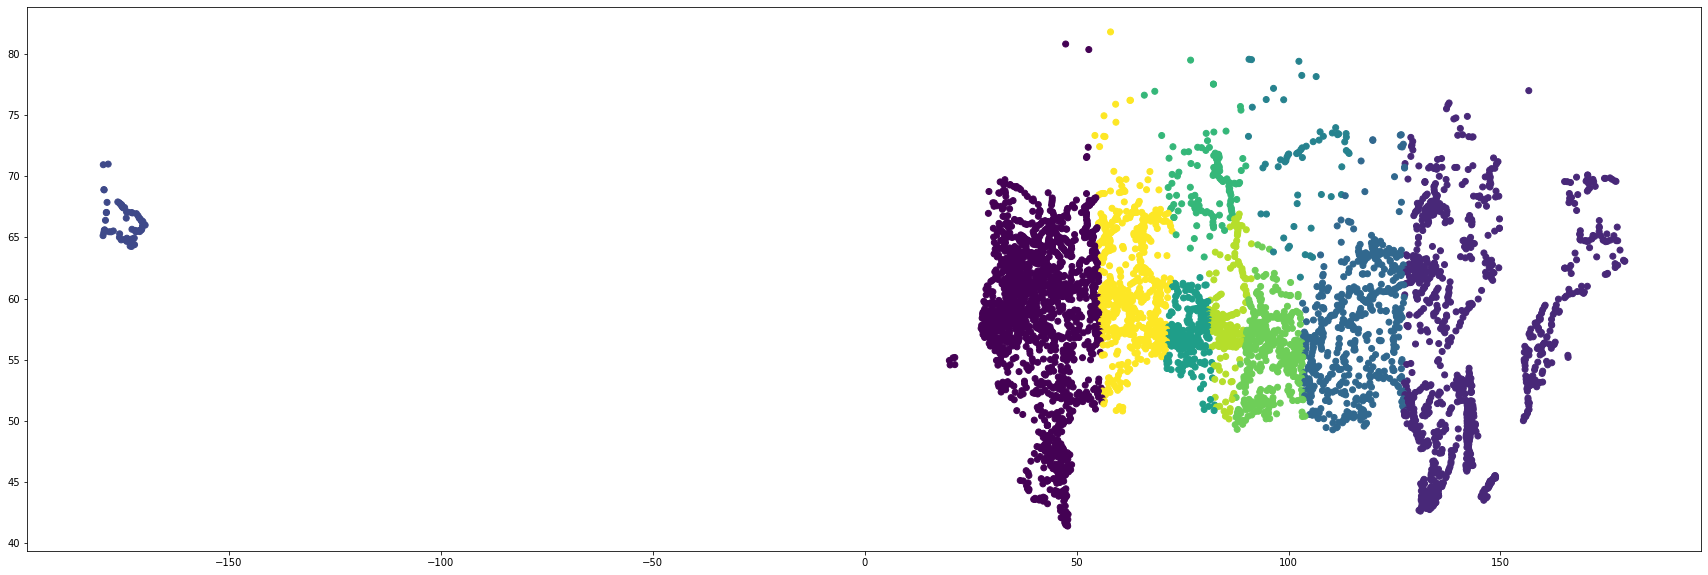

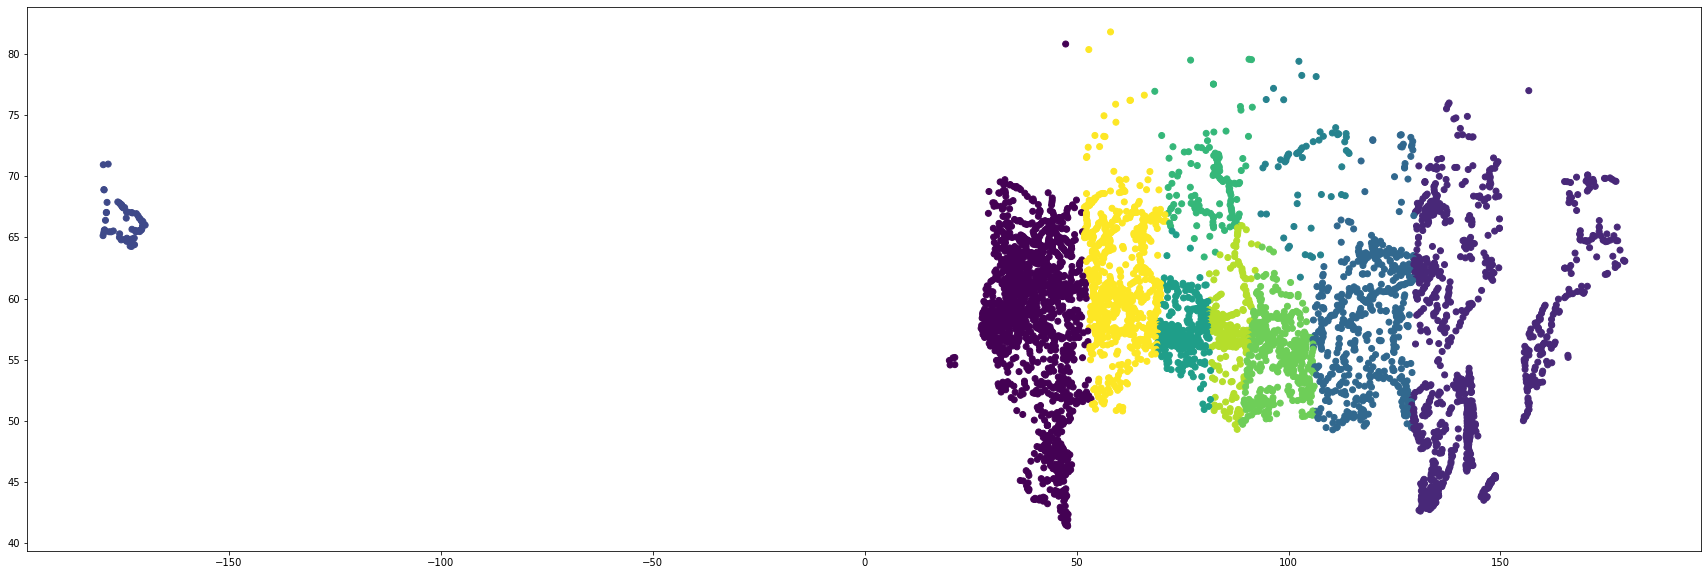

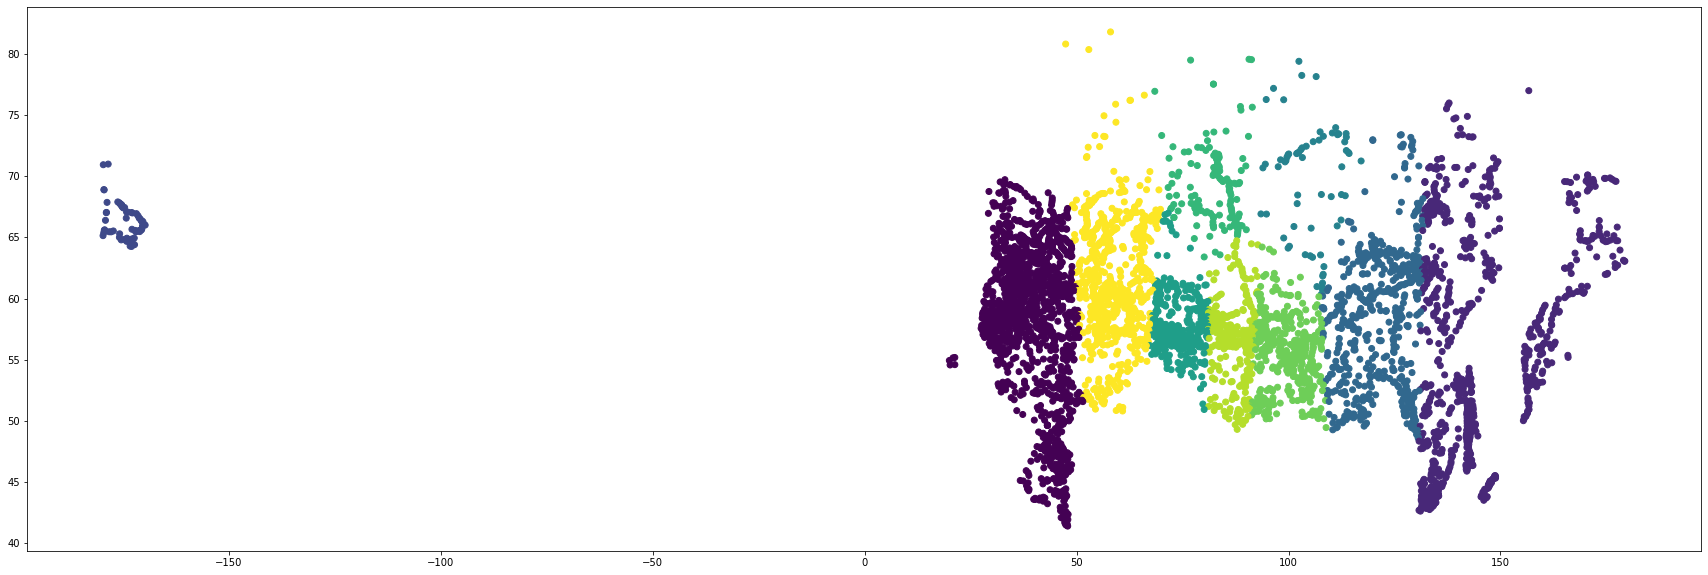

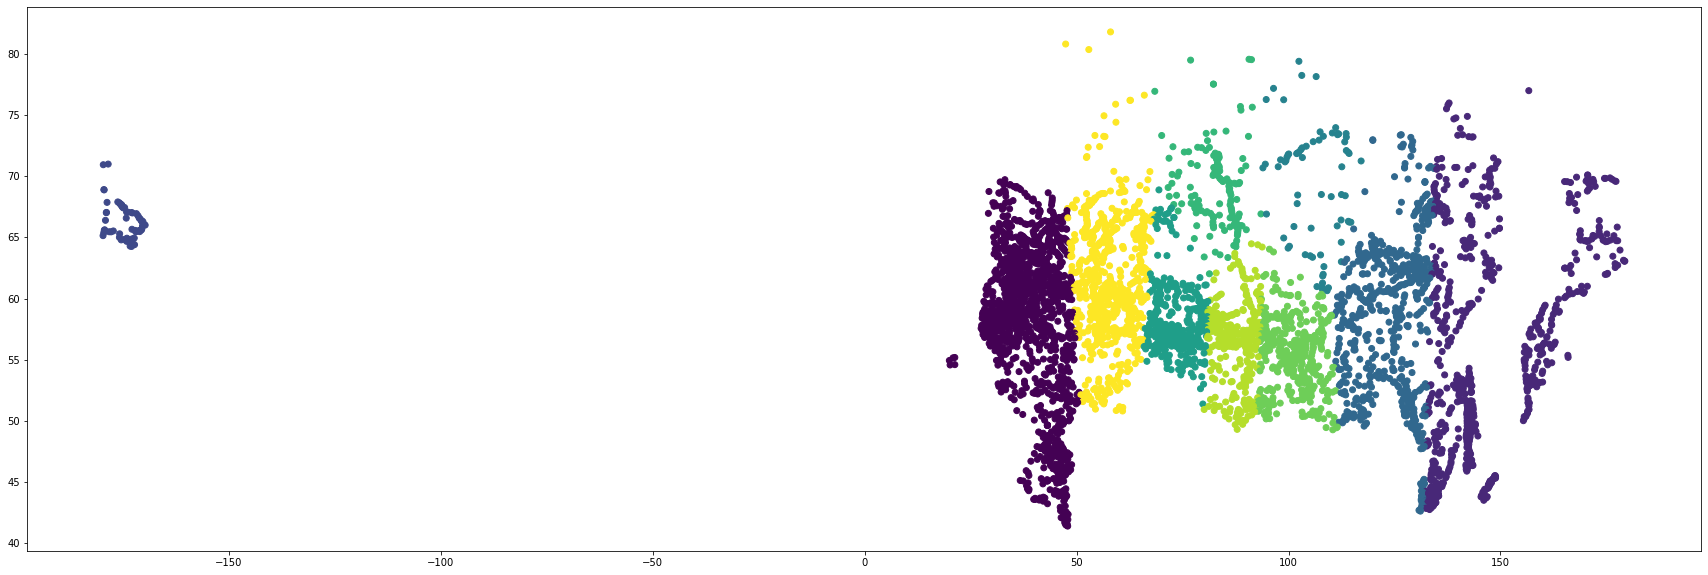

In [35]:
cls = k_means(10)
cls.fit(data.values, visualize=True) # visualize=True выводит график на каждой итерации
y = cls.transform(data.values)

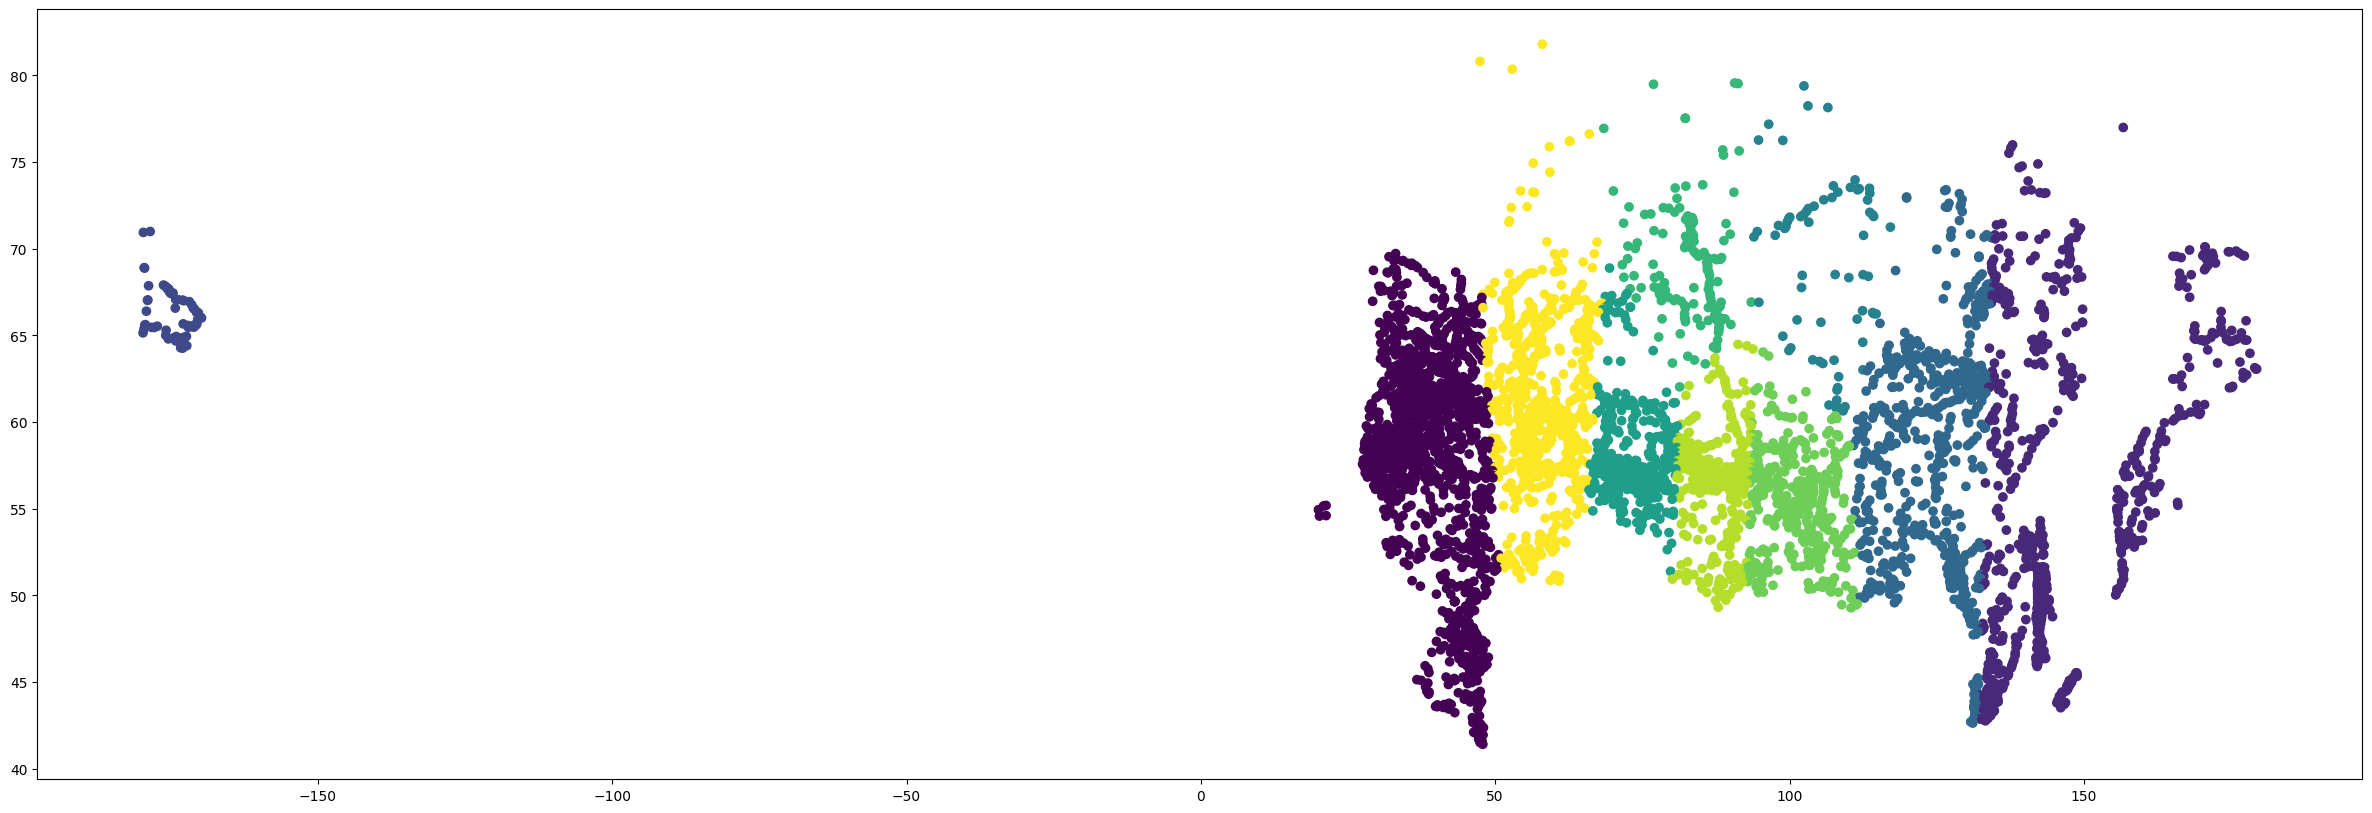

In [ ]:
# Итог

plt.figure(figsize= (30,10))
plt.scatter(data['LONG'], data['LAT'], c=y)

Теперь очередь DBSCAN. Какие ожидания?

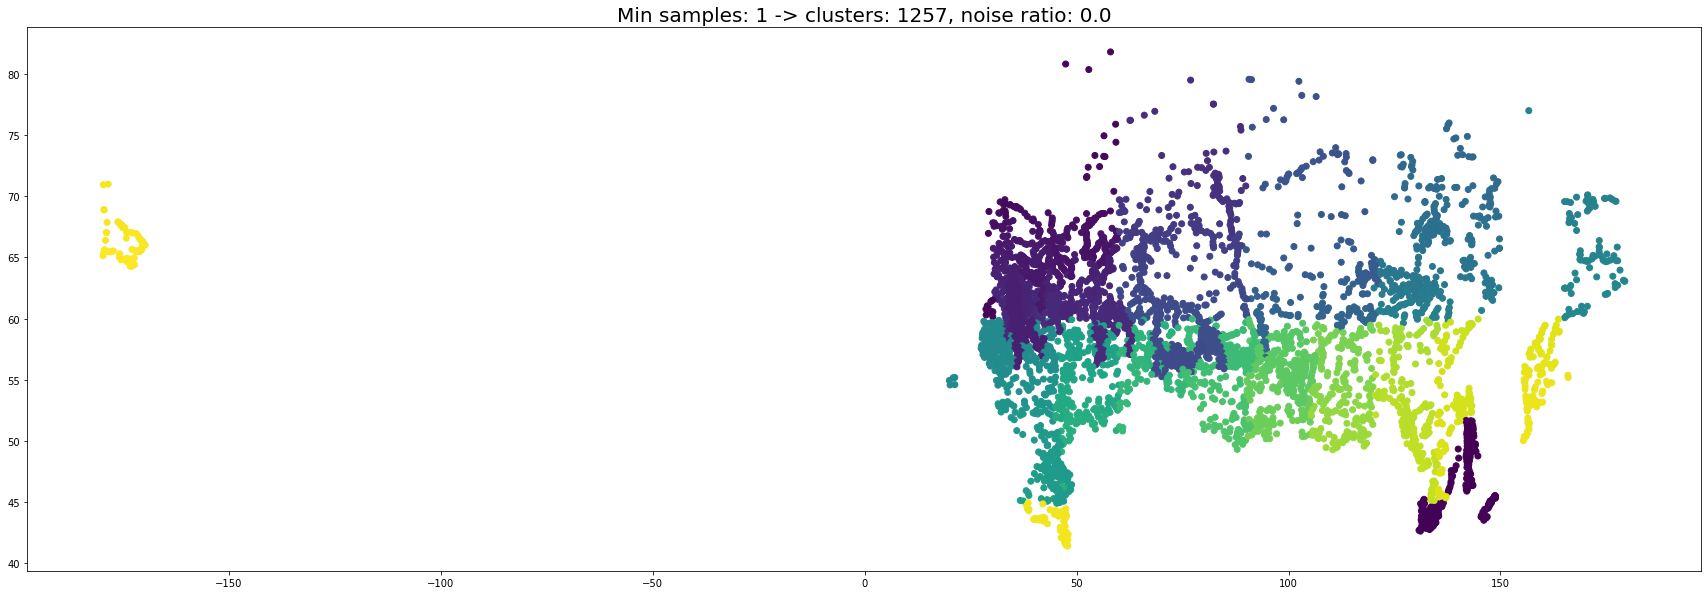

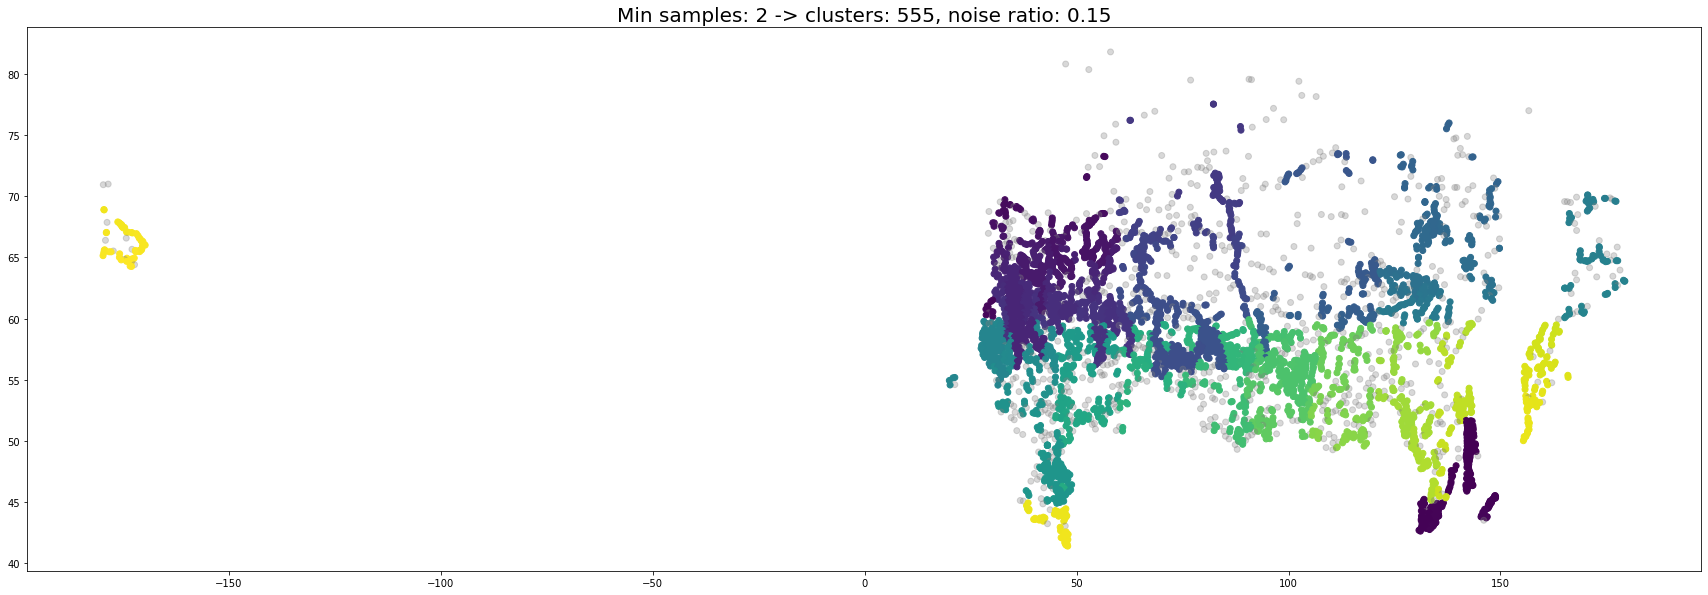

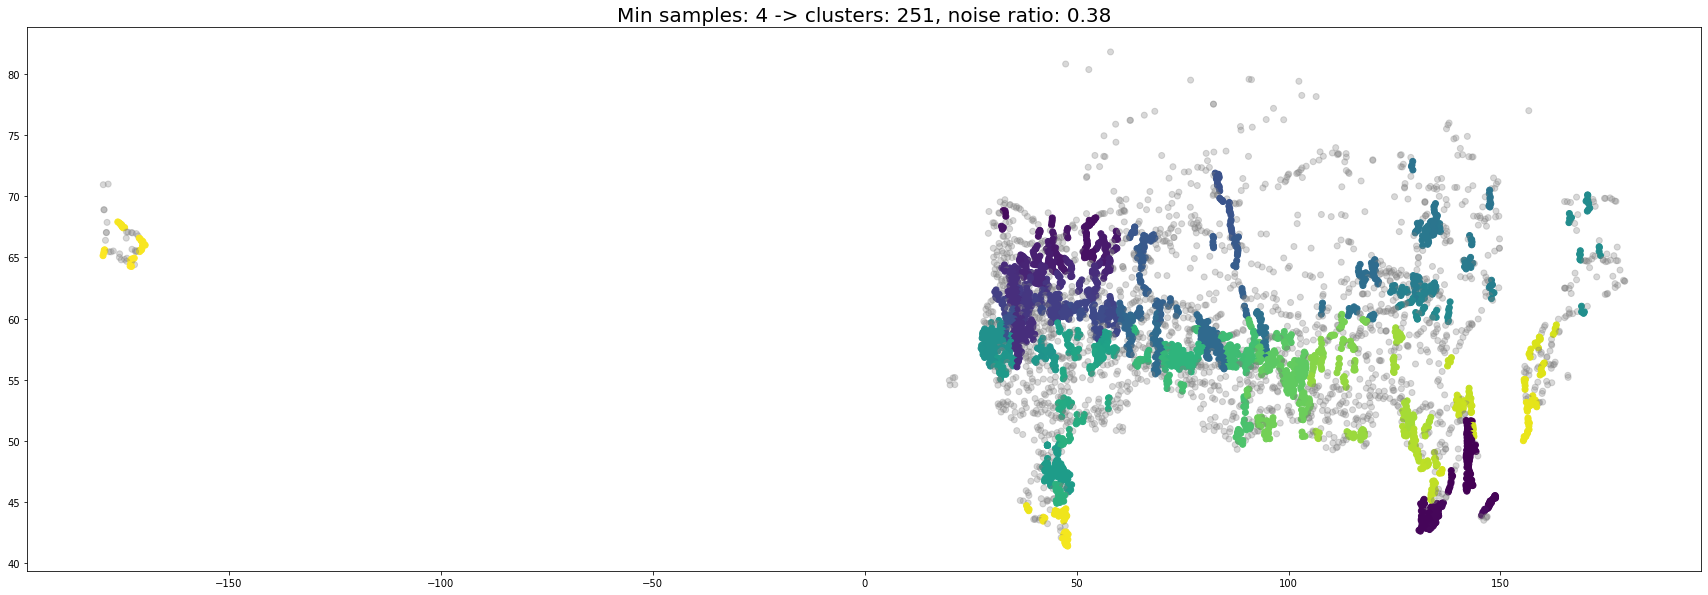

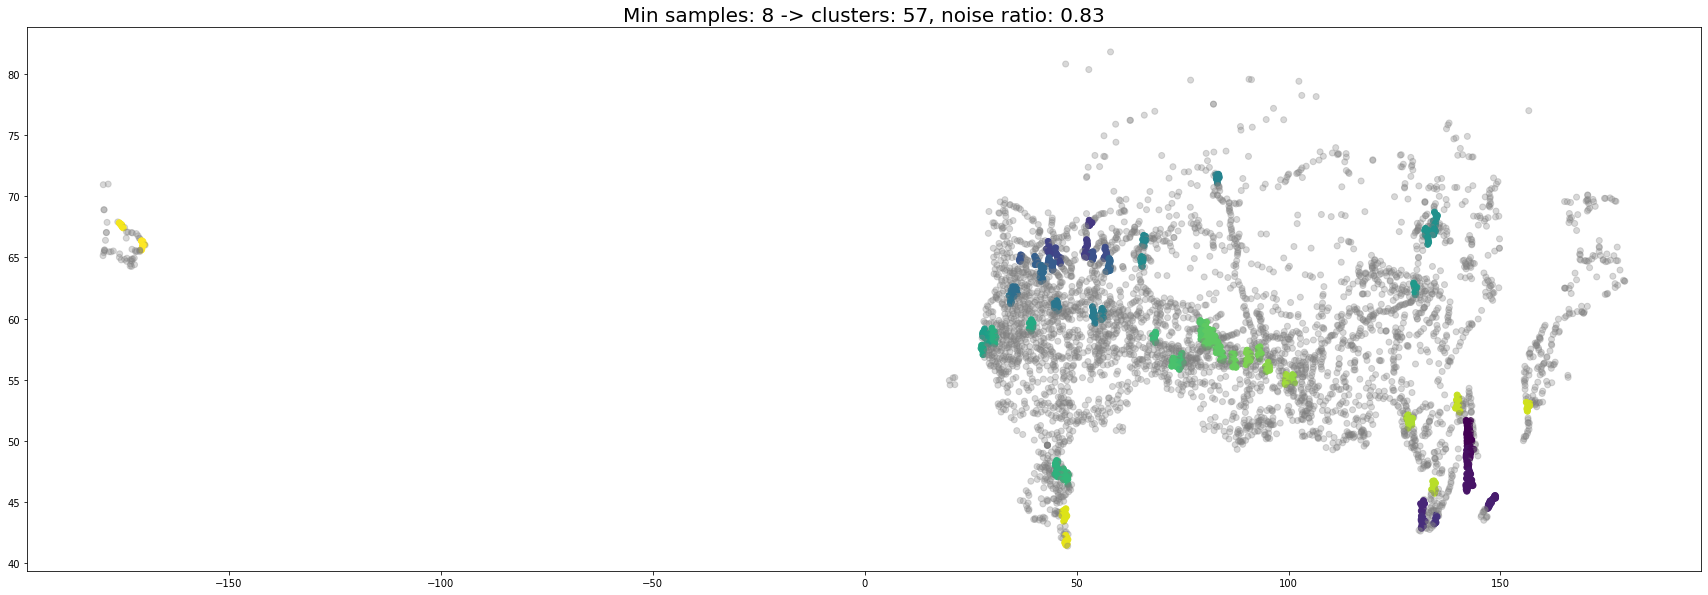

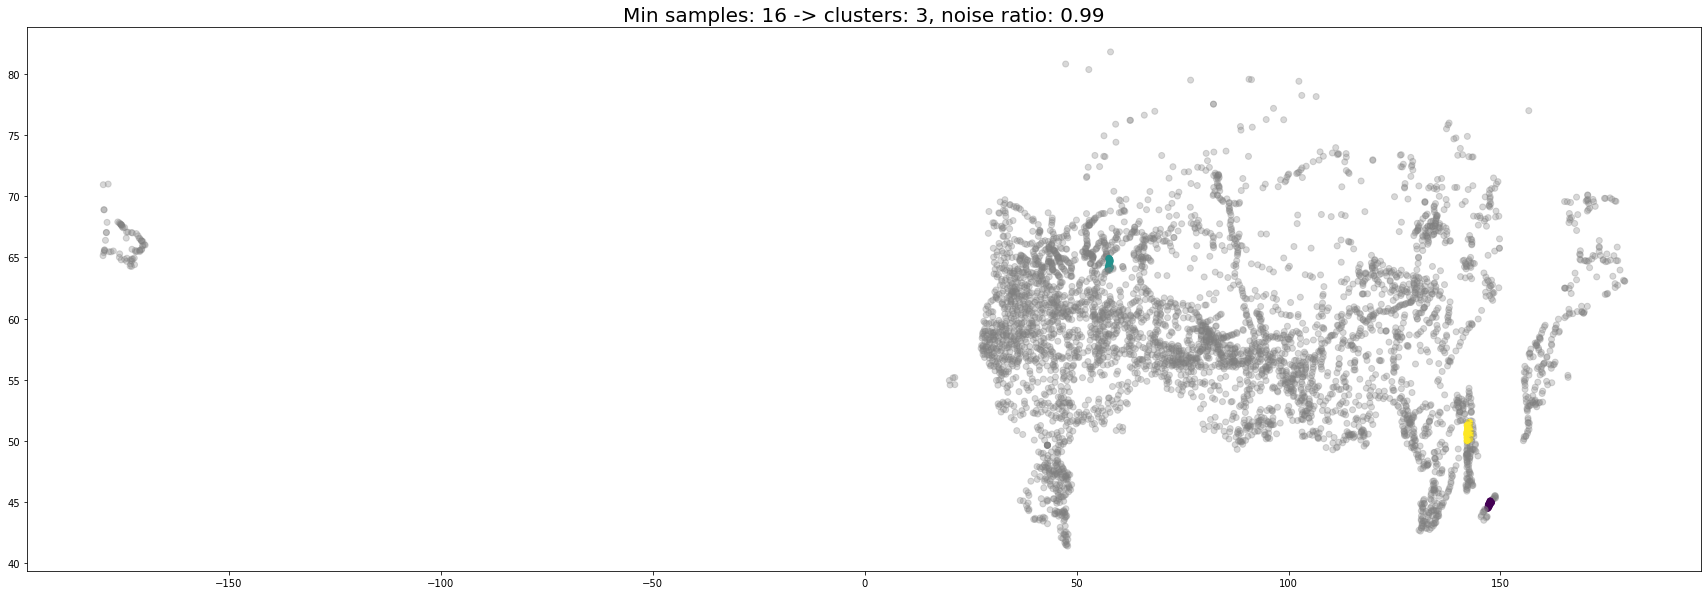

In [36]:
# Пробуем менять min_samples
from sklearn.cluster import DBSCAN
for k in [1, 2, 4, 8, 16]:
    cls = DBSCAN(min_samples=k)
    y = cls.fit_predict(data.values)
    plt.figure(figsize= (30,10))
    colors = get_colors(y)

    plt.scatter(data['LONG'], data['LAT'], c=colors)
    ratio_noise = np.round(len(y[y == -1]) / len(y), 2)
    plt.title("Min samples: {} -> clusters: {}, noise ratio: {}".format(k, len(np.unique(y[y != -1])), ratio_noise), fontsize=20)
    plt.show()

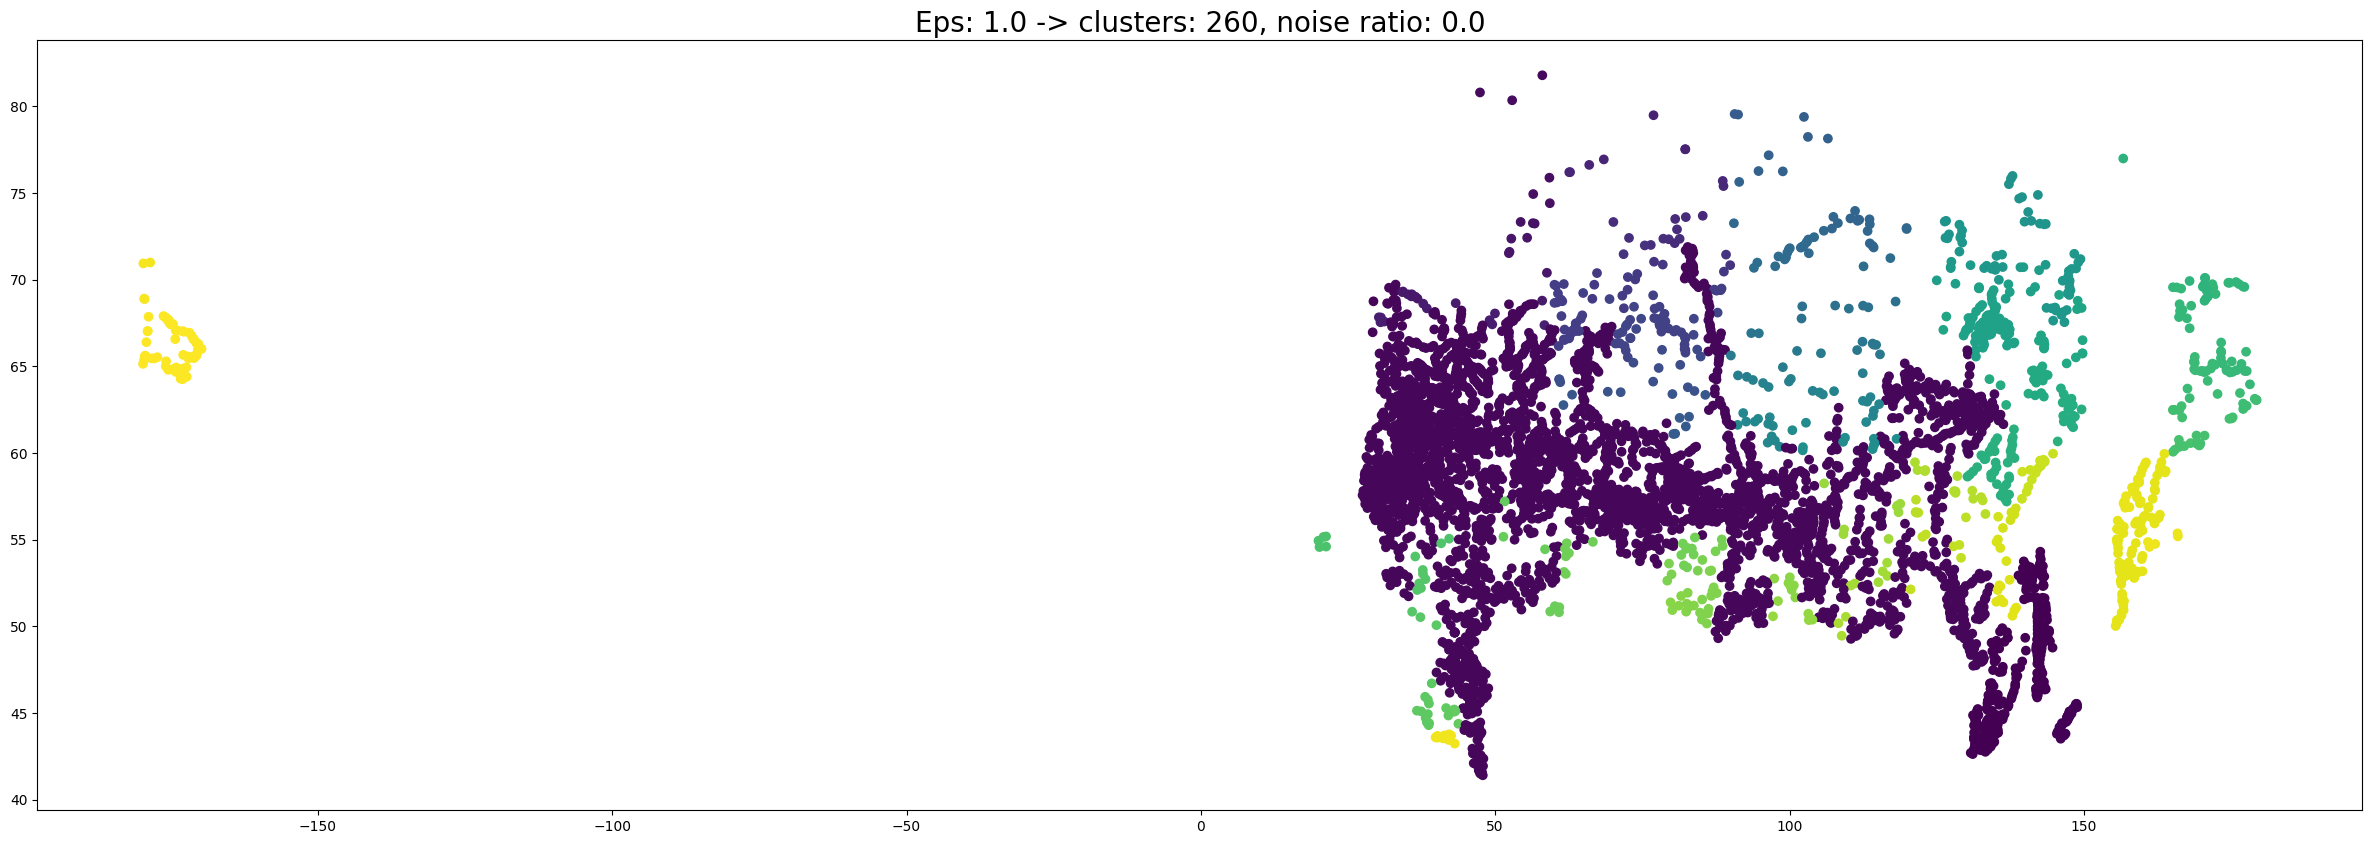

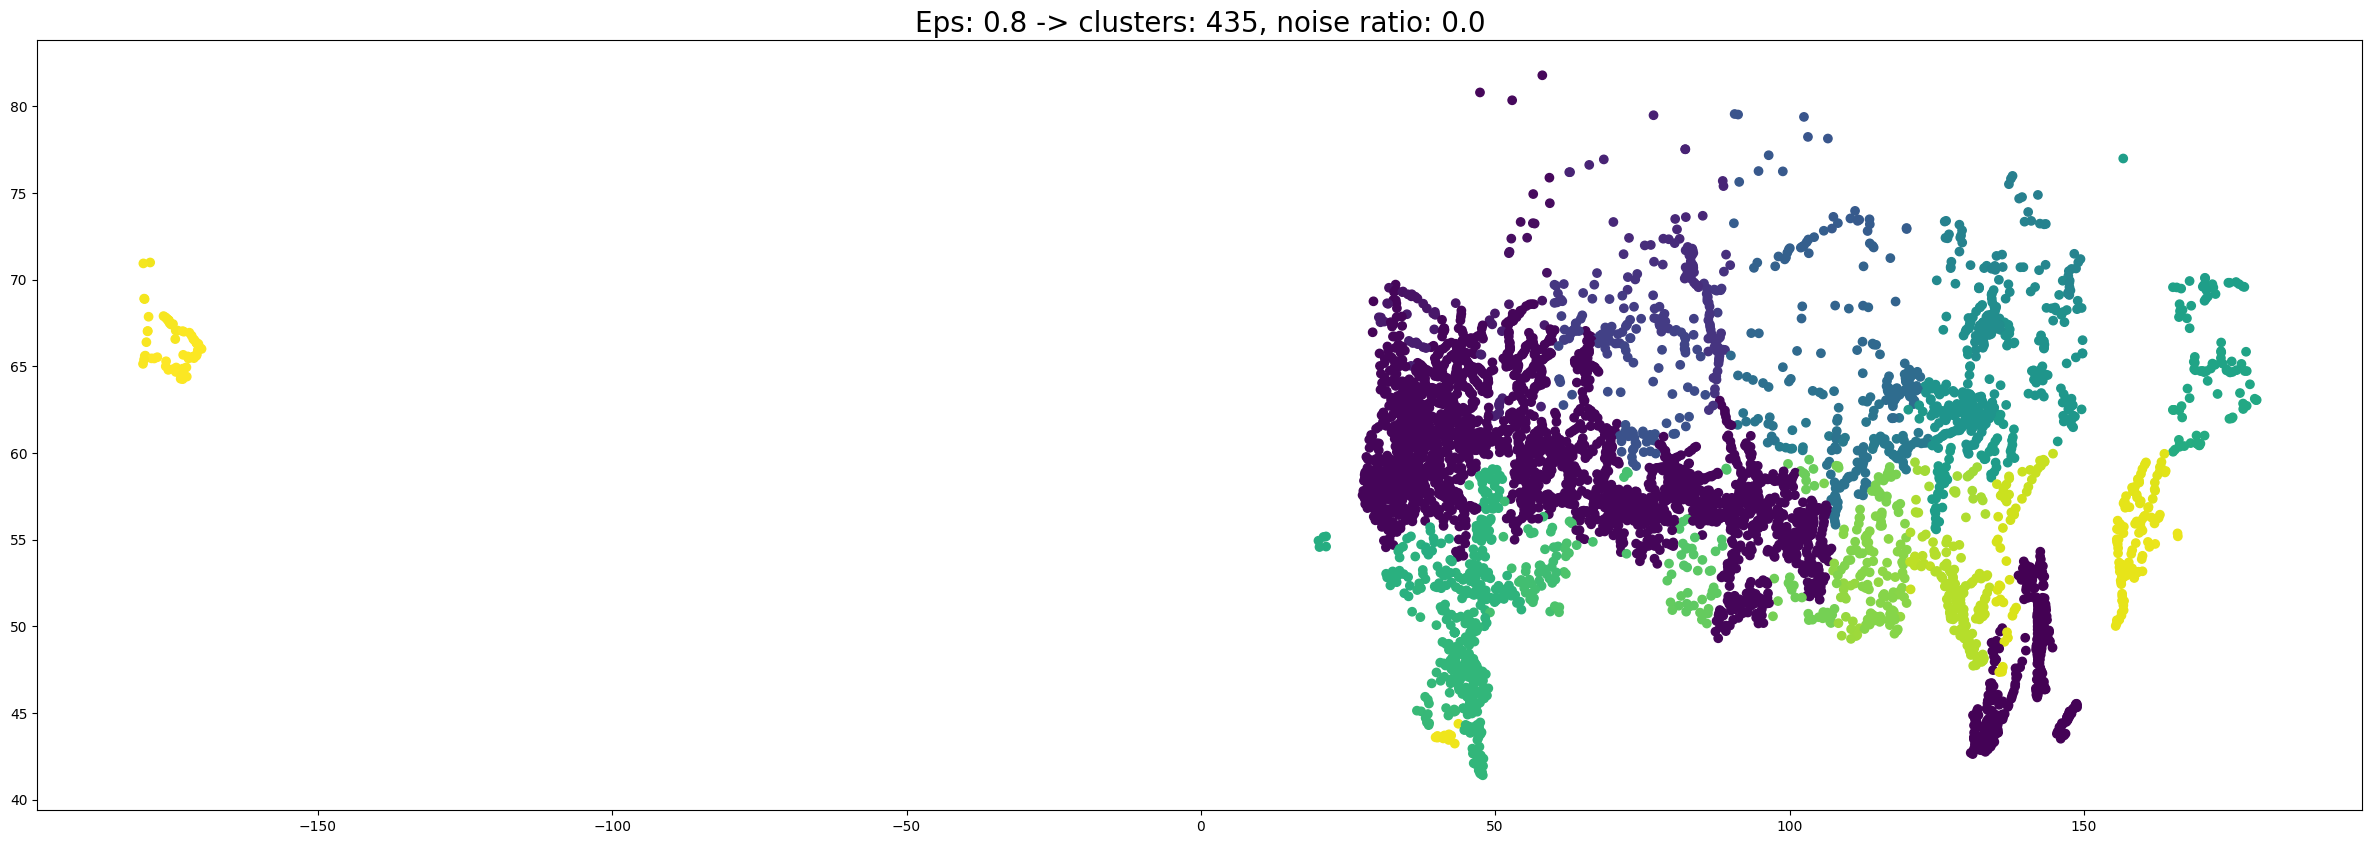

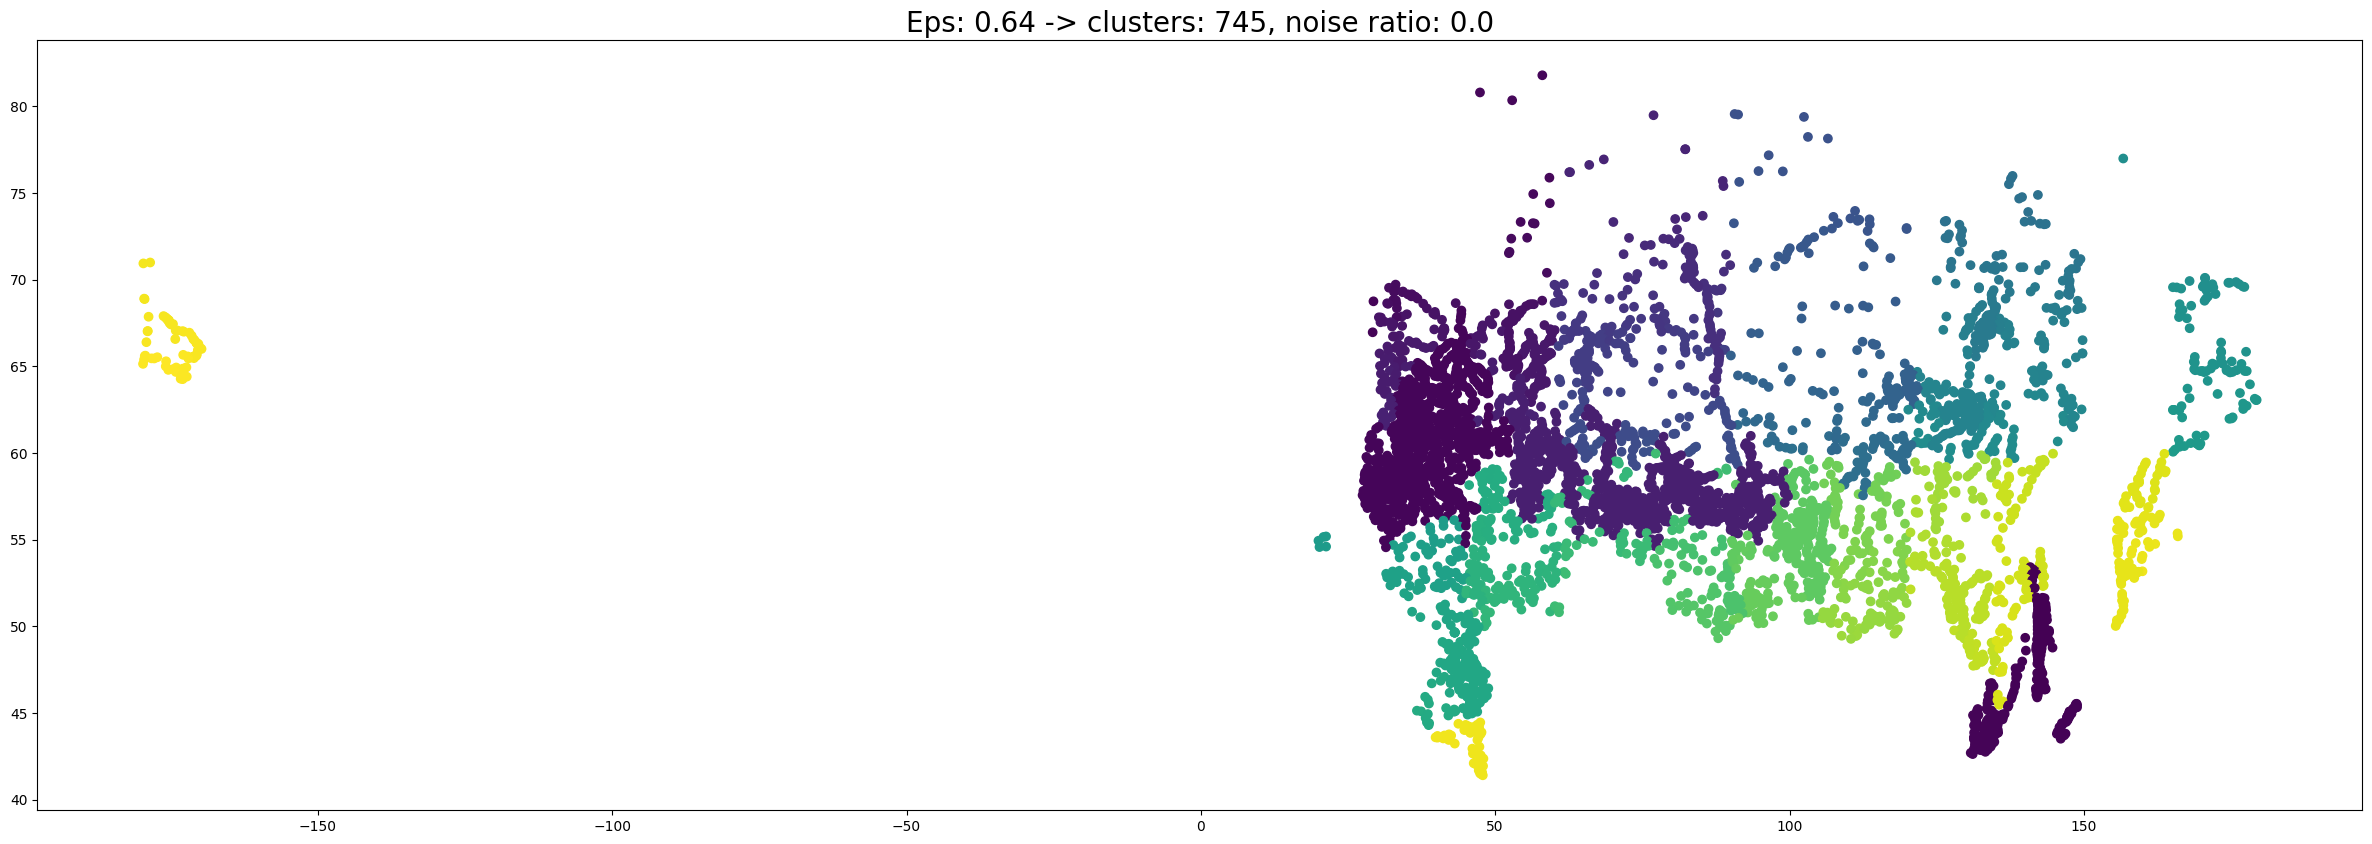

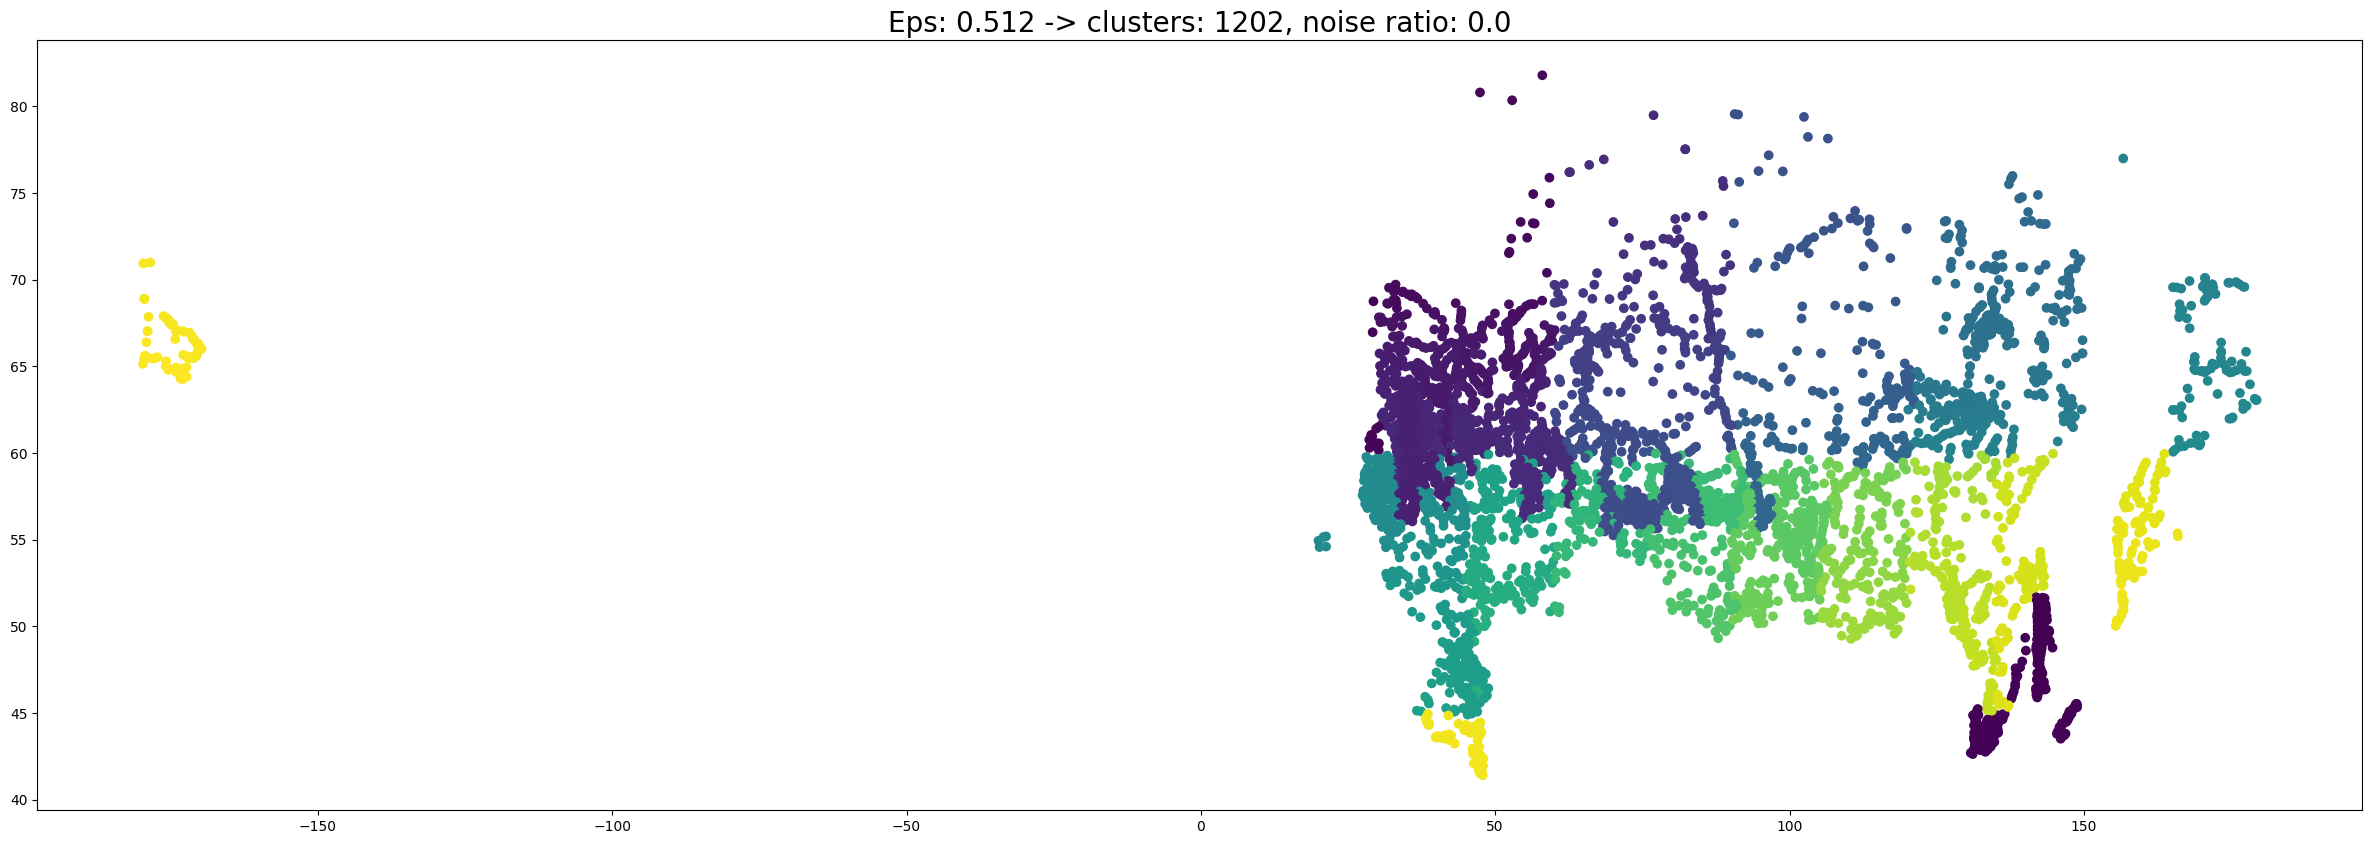

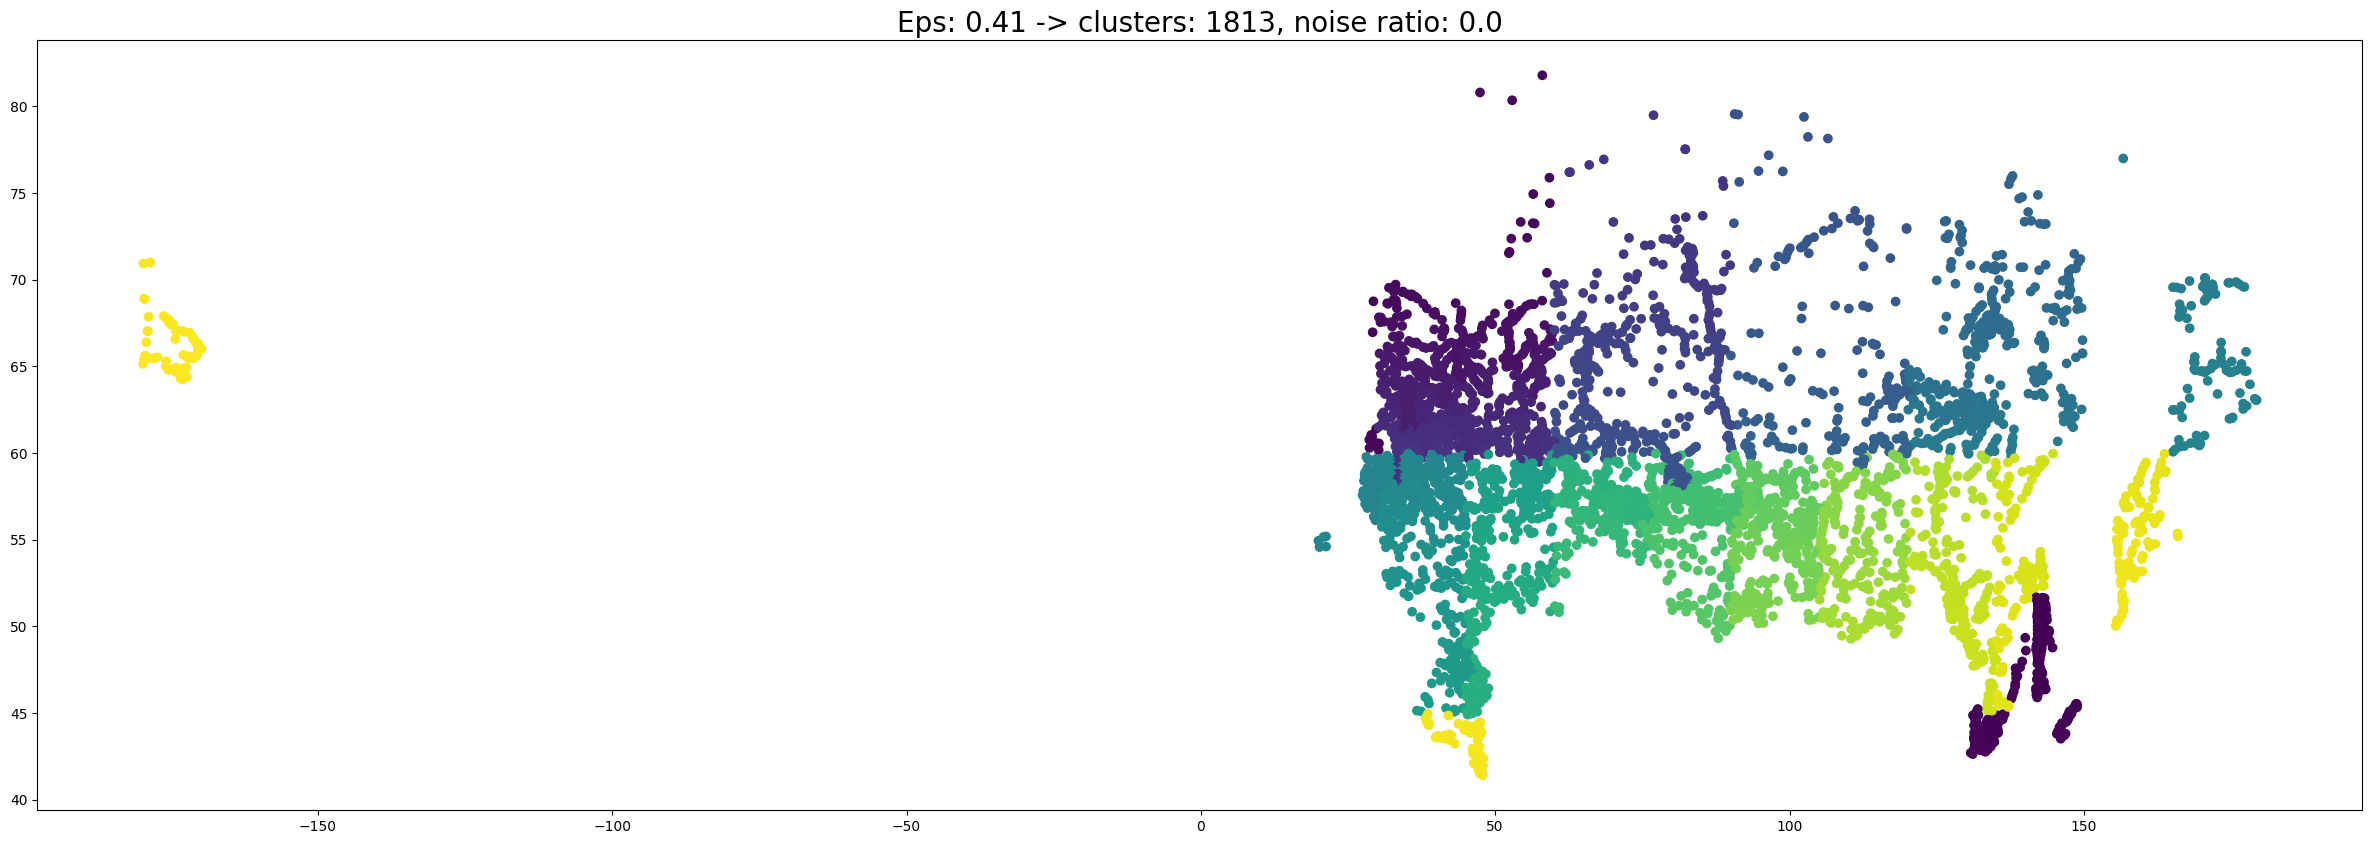

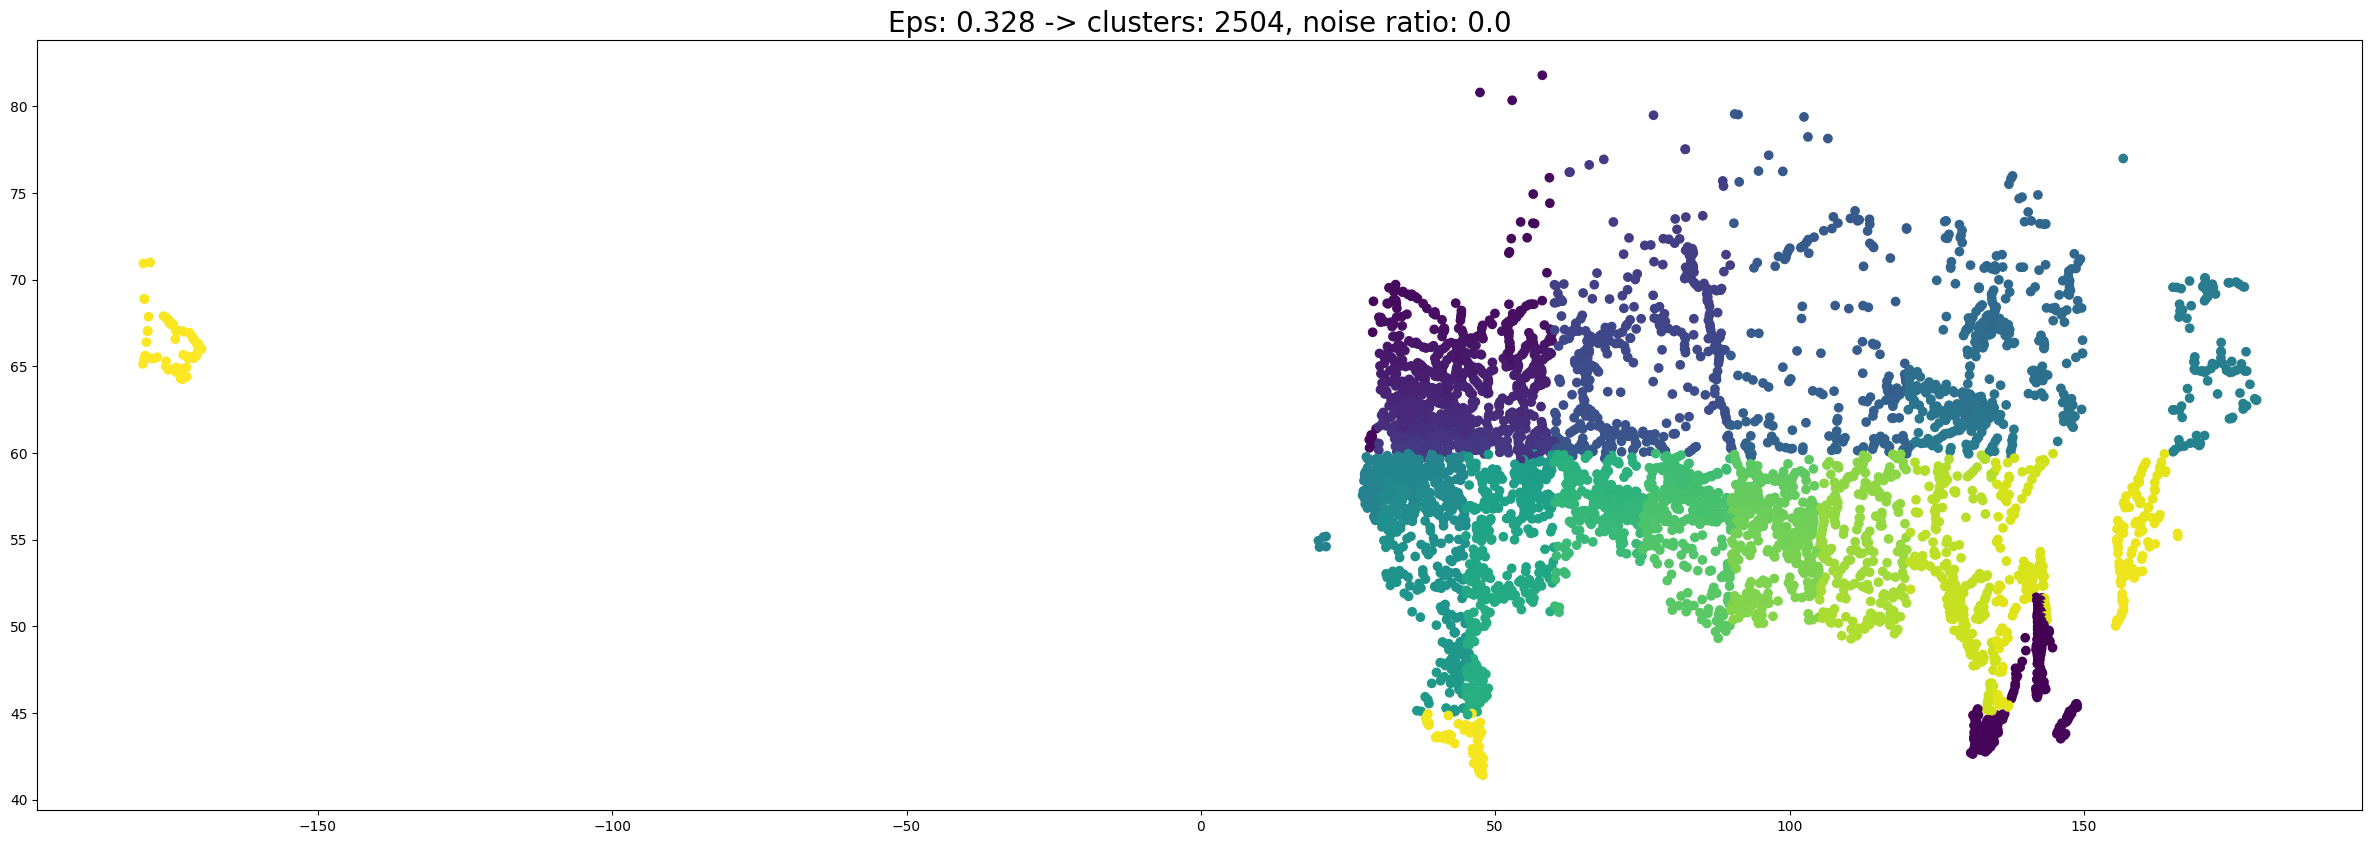

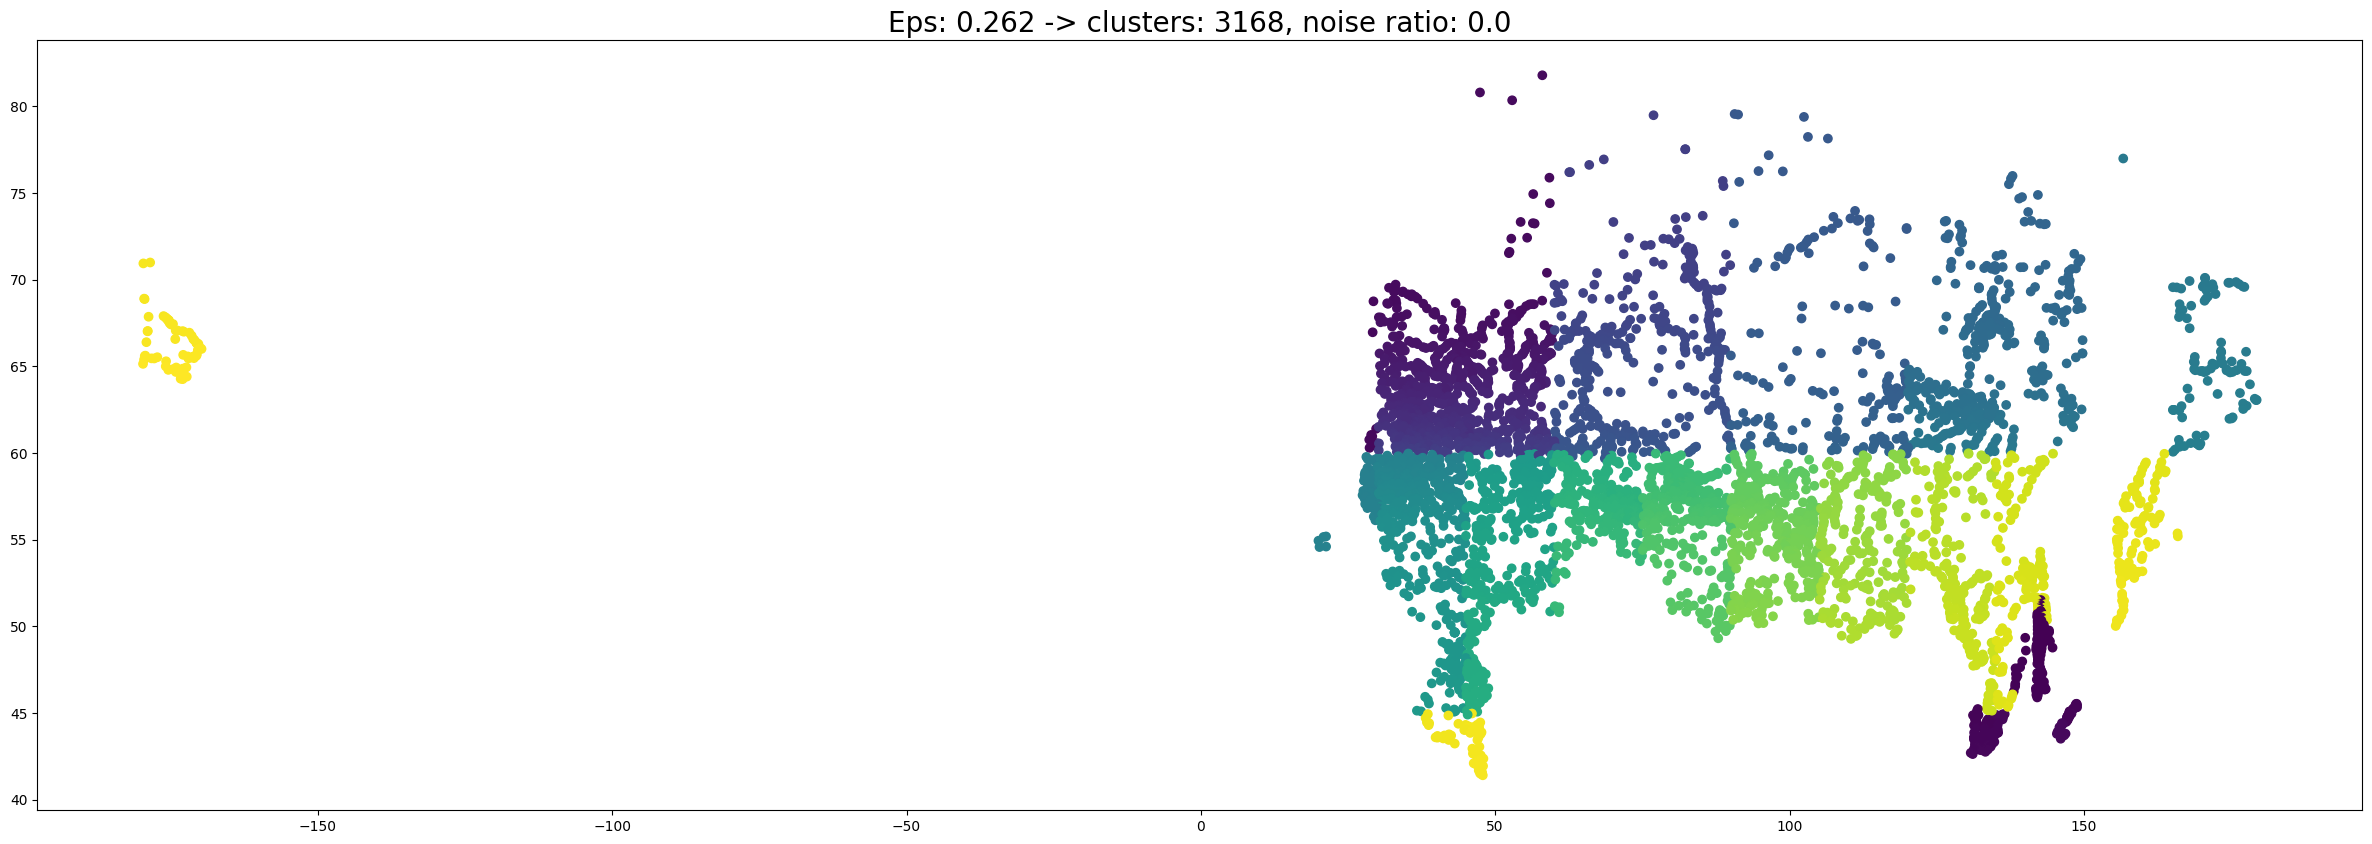

In [ ]:
# Выбрали min_samples = 1
# Пробуем менять eps
from sklearn.cluster import DBSCAN
for eps in 0.8**np.arange(7):
    cls = DBSCAN(min_samples=1, eps=eps)
    y = cls.fit_predict(data.values)
    plt.figure(figsize= (30,10))

    colors = get_colors(y)
    plt.scatter(data['LONG'], data['LAT'], c=colors)
    ratio_noise = np.round(len(y[y == -1]) / len(y), 2)
    plt.title("Eps: {} -> clusters: {}, noise ratio: {}".format(np.round(eps, 3), len(np.unique(y[y != -1])), ratio_noise), fontsize=20)
    plt.show()

Text(0.5, 1.0, 'Eps: 0.512 Min samples: 1 -> clusters: 1202')

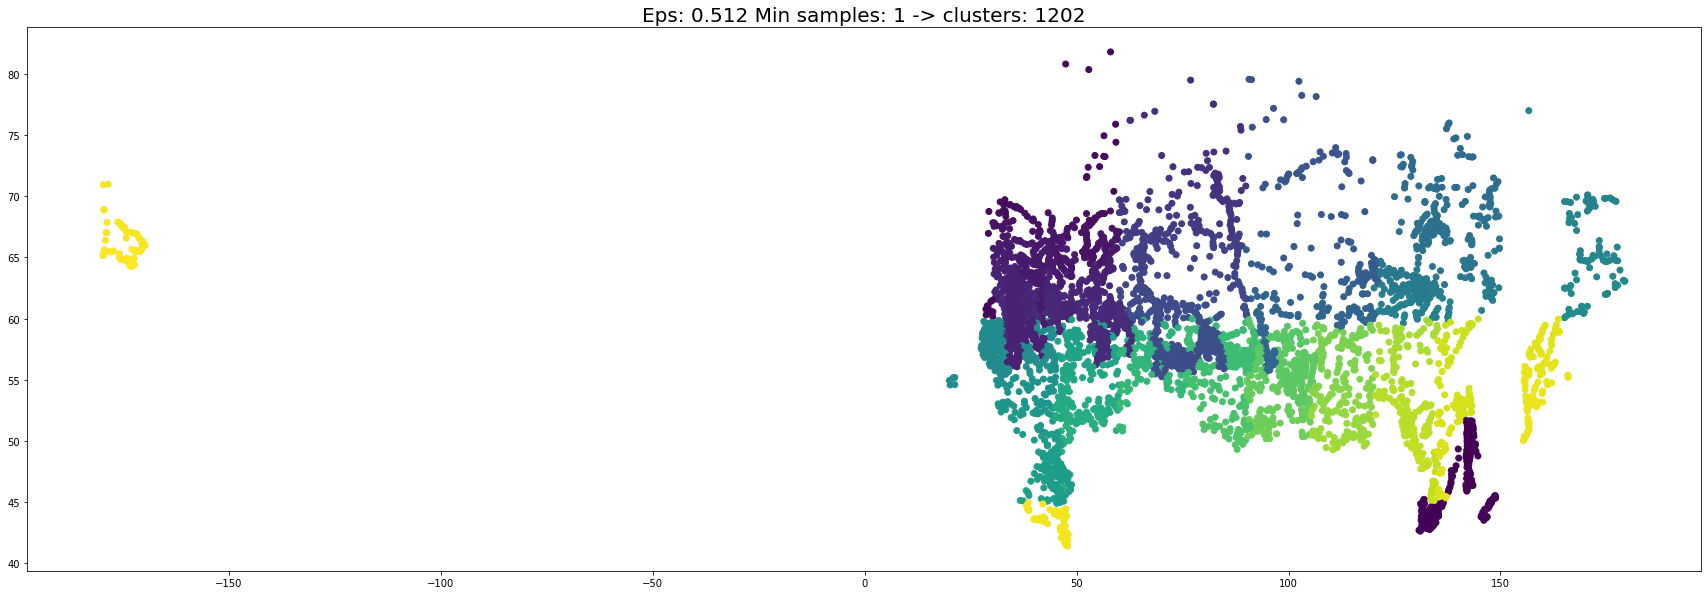

In [37]:
# Итог

cls = DBSCAN(min_samples=1, eps=0.512)
y = cls.fit_predict(data.values)
plt.figure(figsize= (30,10))
colors = get_colors(y)
plt.scatter(data['LONG'], data['LAT'], c=colors)
plt.title("Eps: {} Min samples: {} -> clusters: {}".format(np.round(cls.eps, 3), cls.min_samples, len(np.unique(y[y != -1]))), fontsize=20)


Наконец, можно кластеризовать картинки (пиксели)!

Применим наш метод кластеризации к сегментации изображений. Для этого загрузим картинку и будем каждый ее пиксель рассматривать как отдельный объект с тремя признаками R G B, отвечающими за цвет пикселя. Нам понадобится изменить форму тензора с изображением, вытянув все пиксели вдоль одной оси, чтобы получить матрицу объекты-признаки.

In [38]:
import PIL
import urllib
img = np.array(PIL.Image.open(urllib.request.urlopen('https://raw.githubusercontent.com/iad34/seminars/master/materials/apple.png')))
img.shape

(237, 316, 3)

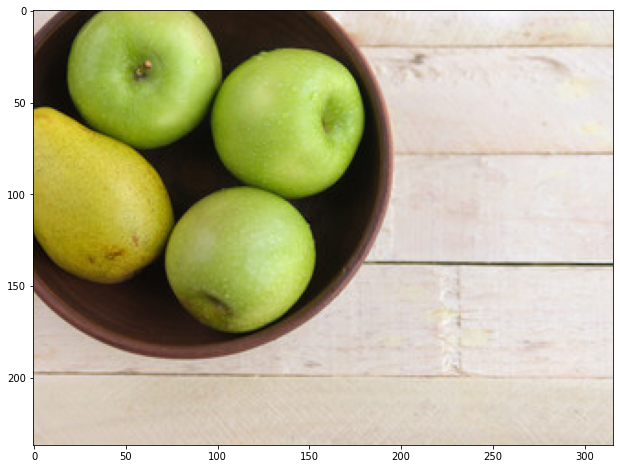

In [39]:
plt.imshow(img)

(237, 316)


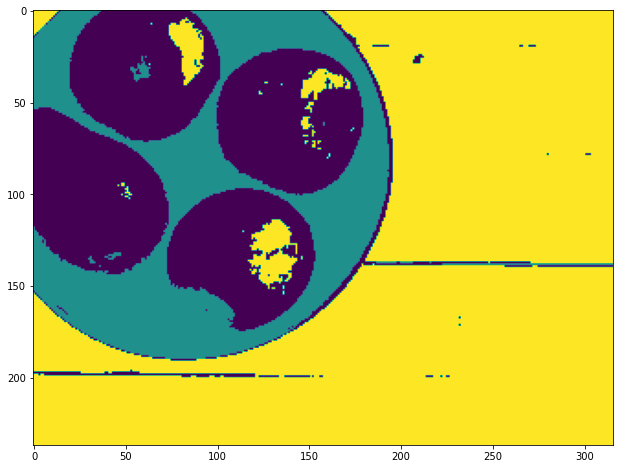

In [40]:
X = img.reshape(-1, 3)
cls = k_means(3)
cls.fit(X)
y = cls.transform(X)
new_img = y.reshape(img.shape[:2])
print(new_img.shape)
plt.imshow(new_img)

Обратите внимание, что при кластеризации никак не учитывалась информация о положении пикселя на изображении, а учитывался только цвет.

**Опциональное задание:** добавьте к трем уже использующимся признакам (RGB) признаки-координаты пикселя. Можно поэкспериментировать с метриками (например, домножать признаки-координаты на какой-то вес-гиперпараметр).

In [ ]:
coords = np.empty((img.shape[0],img.shape[1],2), dtype=int)
coords[:,:,0] = np.arange(img.shape[0])[:,None]
coords[:,:,1] = np.arange(img.shape[1])

#your code here

# Credits:

Ковалев Евгений, Чиркова Надежда, Коган Александра